In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gamma
import scipy.integrate
import pandas
from hmf import MassFunction     # The main hmf class
# TO DO: Update to most recent Planck results
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
import hmf
from hmf import functional
import winsound

In [2]:
# Path to tables of cosmic variance values
path = "../../CV_Vals/"
file='constant'
save=1
# Get young, blue galaxy spectrum
data = np.loadtxt("../erb2010_continuum.dat")
x = data[:,0]
y = data[:,1] * x**2 / 3.e18 # Convert to correct flux values

# Constants
tot_sky = 41253. # Total degrees on the sky
masses = np.array([7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0]) # Mass bins in log(M/Msun)

# TO DO: Modify cosmic variance values from the tables such that masses <= 8 use the same cosmic variance values as 8.5
# Currently the CV values are incorrectly extrapolated to lower masses from a mass of 8.5
# The code used to calculated the CV values is called "getcv" and is included with the CV value files
#Done

trials = 10000 # Number of trials for calculating median from gamma function
mmin = 9 # Minimum halo mass for HMF
mmax = 13.5 # Maximum halo mass for HMF

In [3]:
# Function to find closest wavelength in measured galaxy spectrum compared to given value
def nearest_wavelength(x, val):
    i = (np.abs(x - val)).argmin()
    return x[i]

In [4]:
# Define a class for different survey designs
class survey:
    def __init__(self, ABmax, area, cv_file, wavelength = 0, num_pointings = 1):
        self.ABmax = ABmax # Limiting AB magnitude of the survey
        self.area = area # Survey area
        self.file = cv_file # Name of cosmic variance table file
        self.point = num_pointings # Number of independent pointings
        self.wavelength = wavelength # Center wavelength for the chosen filter

In [5]:
# Method to take one trial of a gamma distribution with a given variance and mean
def trial(sig_v, mean, trials=10000):
    var = sig_v**2*mean**2
    k = mean**2/var
    t = var/mean
    rand = np.rint(np.random.gamma(k, scale=t, size=trials))
    return rand

In [6]:
val=[-0.04418885, -0.95909967]
def lin(x,a=val[0],b=val[1]):
    return a*x+b

In [7]:
dfz = pandas.read_csv(path+"cv_mashian.csv")
z_vals=dfz["z"]
z_vals = z_vals[::-1]

In [8]:
# Find mean, median number of galaxies found for a given survey design
def mean_median(survey, correction = True, random=True):
    # Get survey information
    point = survey.point
    survey_area = survey.area * point
    ABmax = survey.ABmax 
    
    # Absolute magnitude range over which to integrate
    # Range is larger than necessary to include all galaxies
    M = np.linspace(-30, 0, 1000)
    # Redshift values from CV calculations 
    df = pandas.read_csv(path+survey.file)
    if random:
        z_vals = df["z"].values*np.random.uniform(0.98,1.025,size=1)
    else:
        z_vals = df["z"].values
    df.drop(columns=["z"])
    df["z"]=z_vals
    z_vals = z_vals[::-1]

    all_mean = []
    all_sig_v = []
    
    # Loop over z values
    for z in z_vals:
        # Correct magnitude to account for choice of telescope filter
        if(correction):
            # Get observed wavelength for a rest frame of 1600 Angstroms
            # Find closest wavelength to this value in the observed galaxy spectrum
            wl_obs = nearest_wavelength(x, 1600 * (1 + z))
            # Account for difference in observed magnitude due to difference in wavelength 
            # of the survey and the wavelength of the 
            ABmax_new = ABmax + 2.5 * np.log10(y[x==survey.wavelength]/y[x==wl_obs])
        else:
            ABmax_new = ABmax
        
        # Find volume of space within redshift bin
        dz = df.loc[df['z'] == z][["dz"]].values[0][0]
        vol = cosmo.comoving_volume(z + dz/2).value - cosmo.comoving_volume(z - dz/2).value

        # Apparent magnitude range over which to integrate
        m = M + cosmo.distmod(z).value

        # Schechter Extrapolation (Bouwens et al. 2015)
        Ms = -20.95 + 0.01 * (z - 6)
        p = 0.47 * 10**(-0.27 * (z - 6)) * 10**(-3)
        a = -1.87 - 0.1 * (z - 6)
        LF_center = np.log(10)/2.5 * p * (10**(0.4 * (Ms - M)))**(a+1) * np.exp(-10**(0.4 * (Ms - M)))
        means = []
        meds = []
        sigs = []

        # Loop over all mass bins
        for mass in masses:
            
            # Account for difference between Song and Bouwens wavelength
            diff = 2.5 * np.log10(y[x==nearest_wavelength(x,1505)]/y[x==nearest_wavelength(x,1605)])
            if z<8:
                norm=lin(z)
                u_lim = 2. * (norm - mass) + cosmo.distmod(z).value + diff # Dimmest object
                l_lim = 2. * (norm - (mass + 0.5)) + cosmo.distmod(z).value + diff # Brightest object
                u_lim = min(u_lim, ABmax_new) # Compare dimmest object to telescope limit  
                # Apparent magnitude limits for given mass bin using Song et al. 2016
            if z>8:
                norm=-1.313
                u_lim = 2. * (norm - mass) + cosmo.distmod(z).value + diff # Dimmest object
                l_lim = 2. * (norm - (mass + 0.5)) + cosmo.distmod(z).value + diff # Brightest object
                u_lim = min(u_lim, ABmax_new) # Compare dimmest object to telescope limit  
            
            # Find where apparent magnitude is within limits
            if mass == np.max(masses):
                index = np.where(m <= u_lim)
            else:   
                index = np.where((m >= l_lim) & (m <= u_lim))

            # Modify index for integration
            if index[0].size != 0:
                index[0][-1] = index[0][-1] + 1

            # Integrate luminosity function over apparent magnitude to get number density
            int_center = np.trapz(LF_center[index], m[index])
            
            # Multiply by volume to get number
            means.append(int_center * vol * survey_area / tot_sky)
            
            # Get cosmic variance value for this z value and mass bin
            # CV values calculated as in Moster et al. 2010
            sig_v = float(df.loc[df['z'] == z][[str(mass)]].values[0][0]) / np.sqrt(int(point))
            sigs.append(sig_v)

        # Append mean and variance values of all masses for this redshift 
        all_mean.append(means)
        all_sig_v.append(sigs)
        
    all_tot_mean = []
    all_med = []
    
    # Loop over all z values (high to low)
    for i in range(len(z_vals)):
        tot_mean = 0
        tot_trials = np.zeros(trials)
        # Find cumulative mean and median number of observed galaxies up to z
        for j in range(i+1):
            means = all_mean[j]
            sigs = all_sig_v[j]
            # Run trials of gamma distribution to find median
            for k in range(len(masses)):
                if means[k] != 0:
                    one_trial = trial(sigs[k], means[k])
                    tot_trials = tot_trials + one_trial
                    tot_mean += means[k]
        all_tot_mean.append(tot_mean)
        med = np.median(tot_trials)
        all_med.append(med)
        
    return np.array(all_tot_mean), np.array(all_med), z_vals

# Plots

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [43:02<00:00, 51.66s/it]


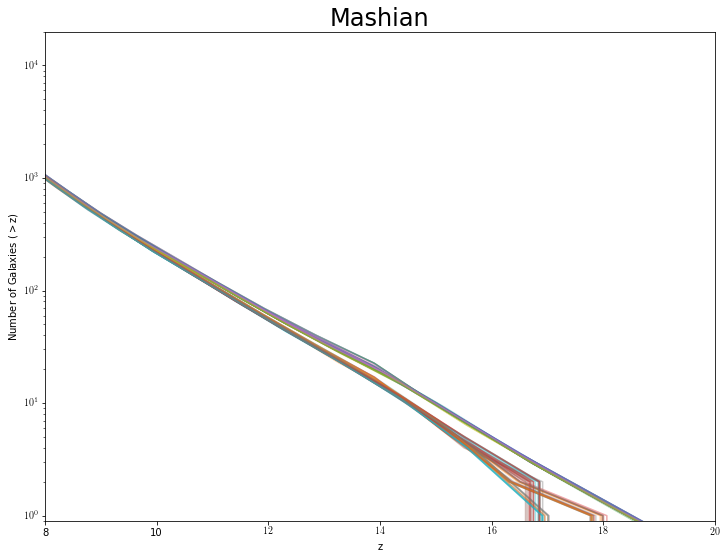

In [9]:
from tqdm import tqdm
N=50
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the idealized survey from Mashian et al. 2015
    mashian = survey(31.5, 200./3600, "cv_mashian.csv", nearest_wavelength(x,14873.4))
    mean_mashian, med_mashian, z_vals_mashian = mean_median(mashian)
    summed+=med_mashian
    summean+=mean_mashian
    plt.rcParams.update({'font.size': 20})
    plt.rc('font', family='serif')
    plt.rc('text', usetex=True)

    ax.plot(z_vals_mashian, mean_mashian, alpha=0.4, label = "Mean")
    ax.plot(z_vals_mashian, med_mashian, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e4), xlim=(8,20), title='Mashian')
    if save==1:
        plt.savefig("figs/"+file+"/mashian.pdf")
winsound.Beep(400,300)

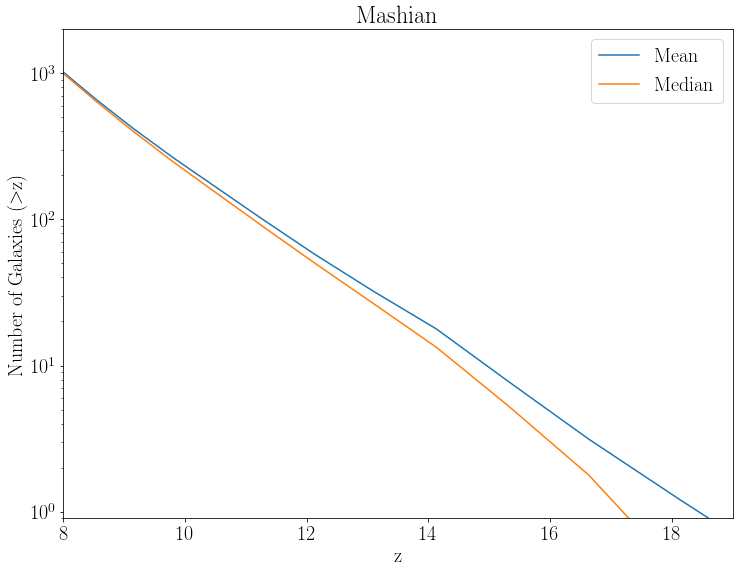

In [10]:
fig, ax =plt.subplots(figsize=(12,9))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,19), title='Mashian')
if save==1:
    plt.savefig("figs/"+file+"/mashian.pdf")

In [11]:
from scipy.interpolate import interp1d
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
def find_min(f):
    x=8
    while f(x)>1:
        x+=0.001
    print(f(x))
    return x

z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9997755942135343
0.9993846173916827


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':


(17.273999999997123, 18.126, 18.427999999998534)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [43:49<00:00, 52.59s/it]


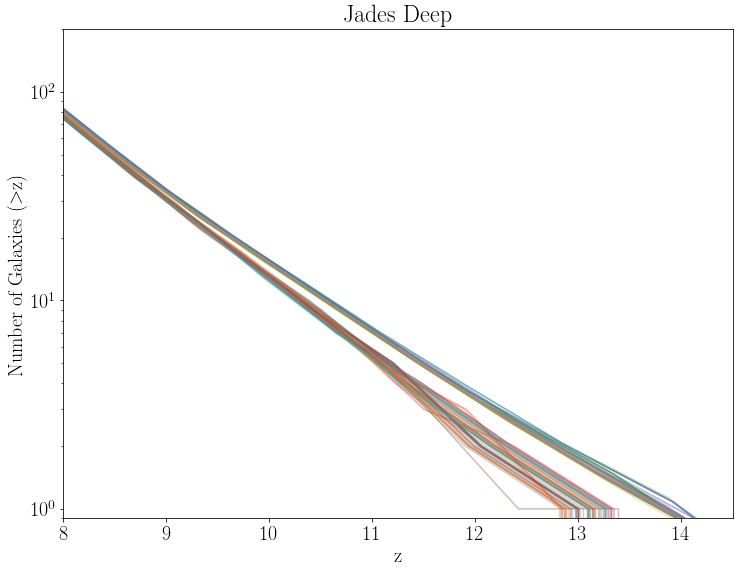

In [12]:
fig, ax = plt.subplots(figsize=(12,9))
meds, means = [],[]
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
    deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
    mean_deep, med_deep, z_vals_deep = mean_median(deep)
    summed+=med_deep
    summean+=mean_deep
    meds.append(med_deep)
    means.append(mean_deep)
    ax.plot(z_vals_deep, mean_deep, alpha=0.4, label = "Mean")
    ax.plot(z_vals_deep, med_deep, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='Jades Deep')
winsound.Beep(400,300)

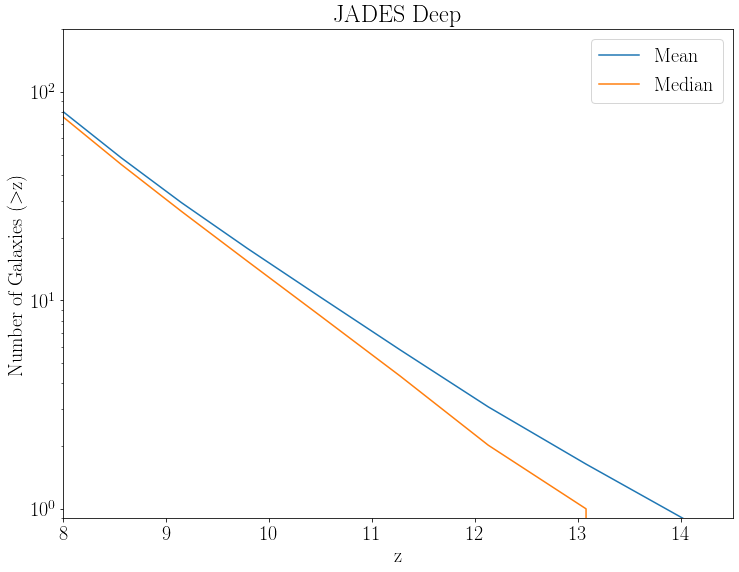

In [13]:
fig, ax =plt.subplots(figsize=(12,9))
meandeepfinal=summean/N
meddeepfinal=summed/N  
ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='JADES Deep')
if save==1:
    plt.savefig("figs/"+file+"/jadesdeep.pdf")

In [14]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9995224208614324
0.9997192564702063


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(13.075999999997187, 13.0755, 13.859999999996752)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [43:25<00:00, 52.12s/it]


0.999905346899007
0.9994744652296732


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in add


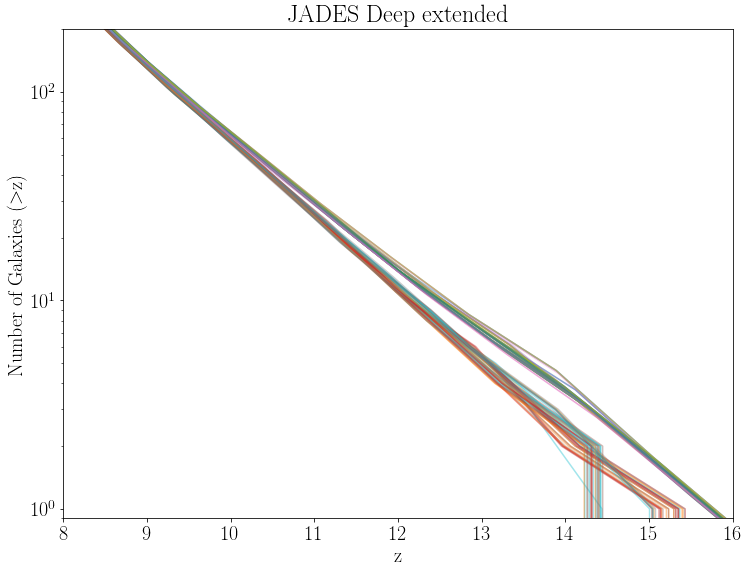

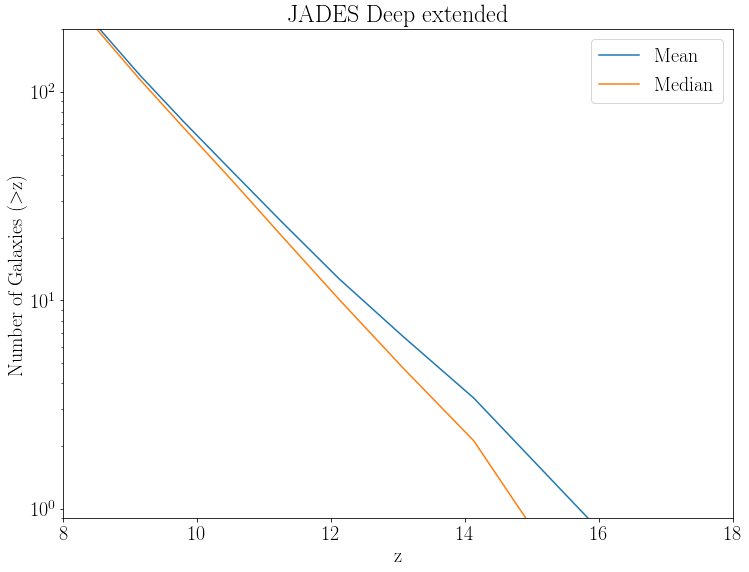

In [15]:
fig, ax = plt.subplots(figsize=(12,9))
meds, means = [],[]
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
    deep = survey(30.7, 190./3600, "cv_jades_deep_extend.csv", nearest_wavelength(x,14873.4))
    mean_deep, med_deep, z_vals_deep = mean_median(deep)
    summed+=med_deep
    summean+=mean_deep
    meds.append(med_deep)
    means.append(mean_deep)
    ax.plot(z_vals_deep, mean_deep, alpha=0.4, label = "Mean")
    ax.plot(z_vals_deep, med_deep, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,16), title='JADES Deep extended')
winsound.Beep(400,300)
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,18), title='JADES Deep extended')
if save==1:
    plt.savefig("figs/"+file+"/jadesdeepextend.pdf")
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean
meandeepEfinal=summean/N
meddeepEfinal=summed/N

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [39:28<00:00, 47.37s/it]


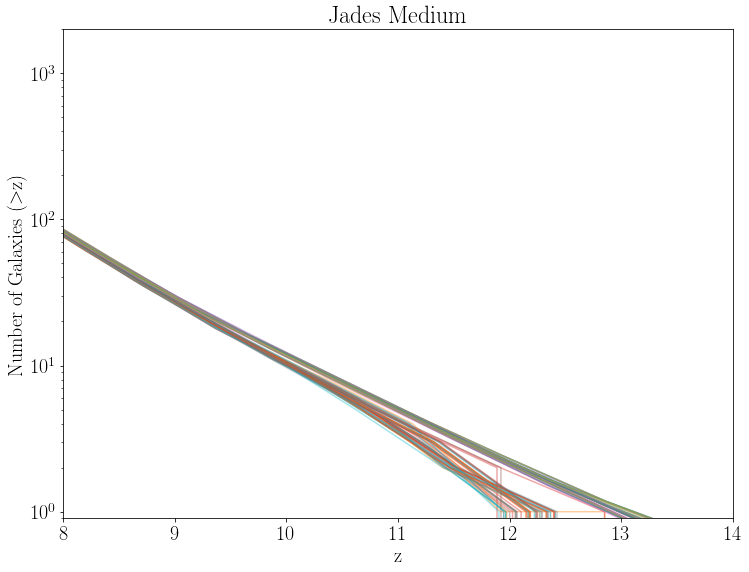

In [16]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Wide survey from Williams et al. 2018 (pg. 36)

    wide = survey(29.8, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
    mean_wide, med_wide, z_vals_wide = mean_median(wide)
    summed+=med_wide
    summean+=mean_wide

    ax.plot(z_vals_wide, mean_wide, alpha=0.4, label = "Mean")
    ax.plot(z_vals_wide, med_wide, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,14), title='Jades Medium')
winsound.Beep(400,300)

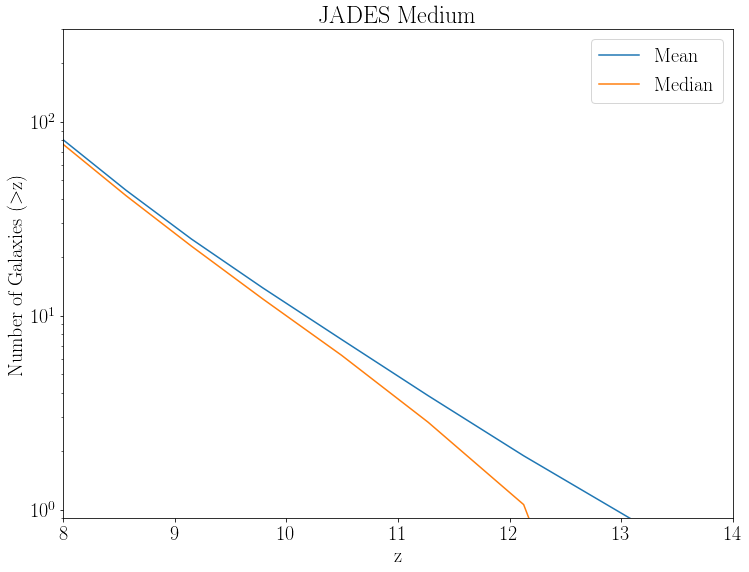

In [17]:
fig, ax =plt.subplots(figsize=(12,9))
meanwidefinal=summean/N
medwidefinal=summed/N  
ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,3e2), xlim=(8,14), title='JADES Medium')
if save==1:
    plt.savefig("figs/"+file+"/jadesmedium.pdf")

In [18]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.998786604526312
0.9993052463275442


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(12.16799999999769, 13.0755, 12.938999999997263)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [38:48<00:00, 46.57s/it]


0.9986563969596757
0.9999990617050826


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in add


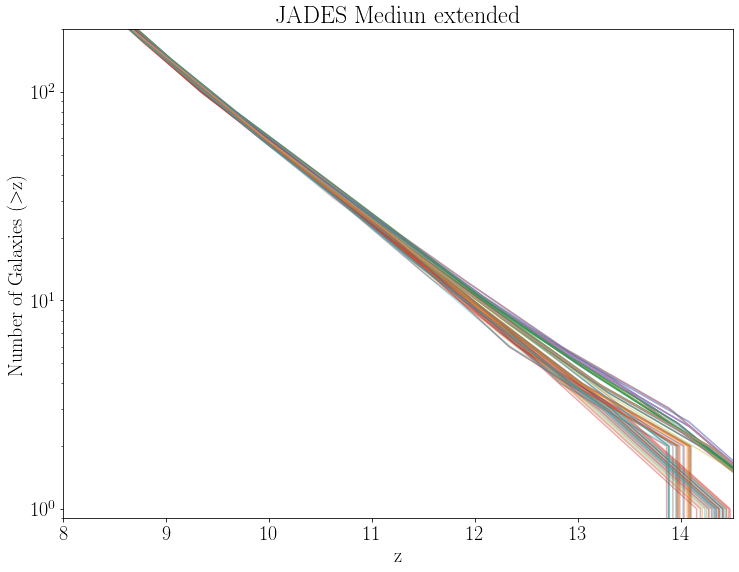

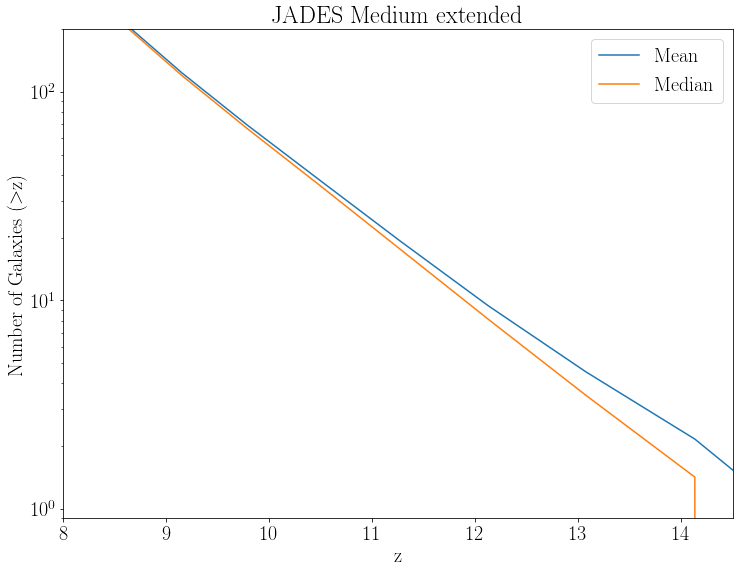

In [19]:
fig, ax = plt.subplots(figsize=(12,9))
meds, means = [],[]
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
    deep = survey(29.8, 5*190./3600, "cv_jades_medium_extend.csv", nearest_wavelength(x,14873.4))
    mean_deep, med_deep, z_vals_deep = mean_median(deep)
    summed+=med_deep
    summean+=mean_deep
    meds.append(med_deep)
    means.append(mean_deep)
    ax.plot(z_vals_deep, mean_deep, alpha=0.4, label = "Mean")
    ax.plot(z_vals_deep, med_deep, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='JADES Mediun extended')
winsound.Beep(400,300)
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='JADES Medium extended')
if save==1:
    plt.savefig("figs/"+file+"/jadesmediumextend.pdf")
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean
meanwideEfinal=summean/N
medwideEfinal=summed/N

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [49:37<00:00, 59.55s/it]


0.9992761932062235
0.9994977387142926


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in add


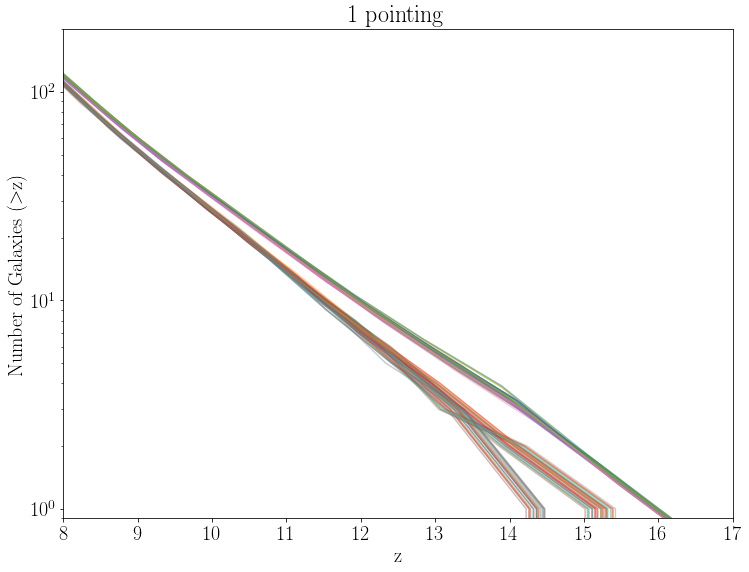

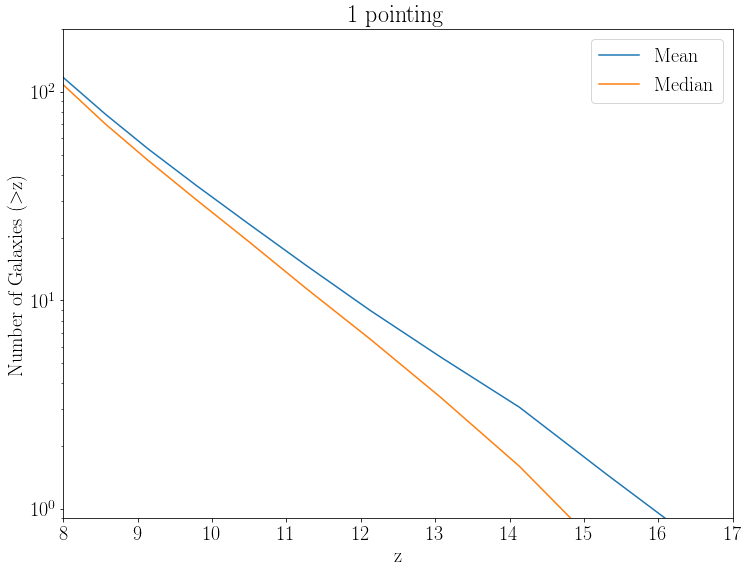

In [20]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 35 parallel pointings of JWST
    # Uses limiting magnitude from JADES Deep, area of one JWST pointing

    parallel_35 = survey(32.2, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1)
    mean_35, med_35, z_vals_35 = mean_median(parallel_35)
    summed+=med_35
    summean+=mean_35

    ax.plot(z_vals_35, mean_35, alpha=0.4, label = "Mean")
    ax.plot(z_vals_35, med_35, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,17), title='1 pointing')
winsound.Beep(400,300)
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,17), title='1 pointing')
if save==1:
    plt.savefig("figs/"+file+"/1.pdf")
mean1final=summean/N
med1final=summed/N      
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean
meandeepEfinal=summean/N
meddeepEfinal=summed/N

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [41:40<00:00, 50.01s/it]


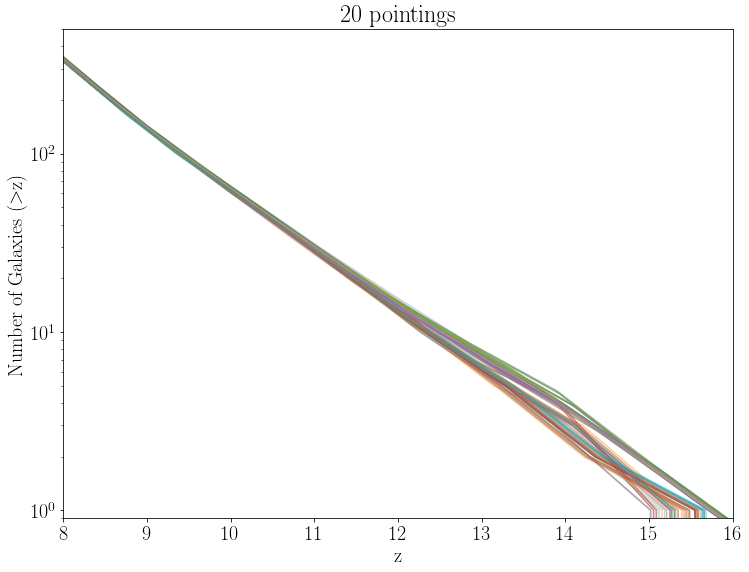

In [21]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 35 parallel pointings of JWST
    # Uses limiting magnitude from JADES Deep, area of one JWST pointing

    parallel_35 = survey(30.7, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 20)
    mean_35, med_35, z_vals_35 = mean_median(parallel_35)
    summed+=med_35
    summean+=mean_35

    ax.plot(z_vals_35, mean_35, alpha=0.4, label = "Mean")
    ax.plot(z_vals_35, med_35, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='20 pointings')
winsound.Beep(400,300)

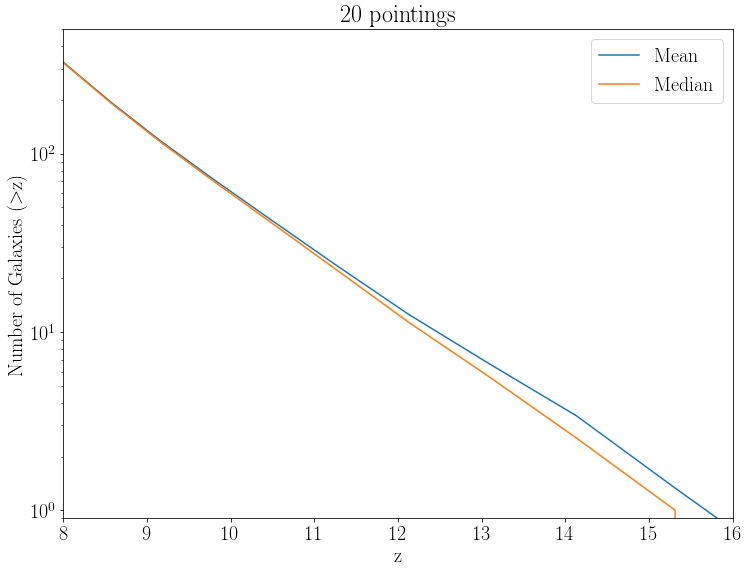

In [22]:
fig, ax =plt.subplots(figsize=(12,9))
mean20final=summean/N
med20final=summed/N  
ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='20 pointings')
if save==1:
    plt.savefig("figs/"+file+"/20.pdf")

In [23]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9990370671091559
0.9996587852758747


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(15.311999999995948, 15.311, 15.64899999999576)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [37:09<00:00, 44.60s/it]


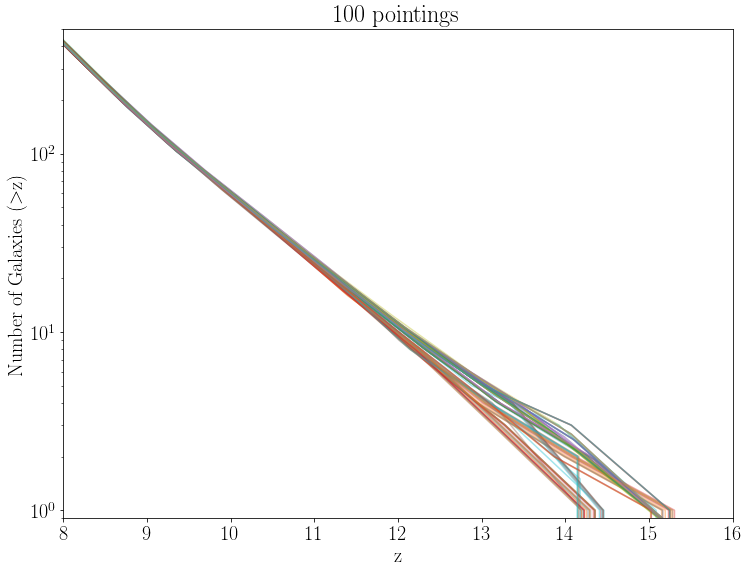

In [24]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 100 parallel pointings of JWST

    parallel_200 = survey(29.8, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 100)
    mean_200, med_200, z_vals_200 = mean_median(parallel_200)
    summed+=med_200
    summean+=mean_200

    ax.plot(z_vals_200, mean_200, alpha=0.4, label = "Mean")
    ax.plot(z_vals_200, med_200, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='100 pointings')
winsound.Beep(400,300)

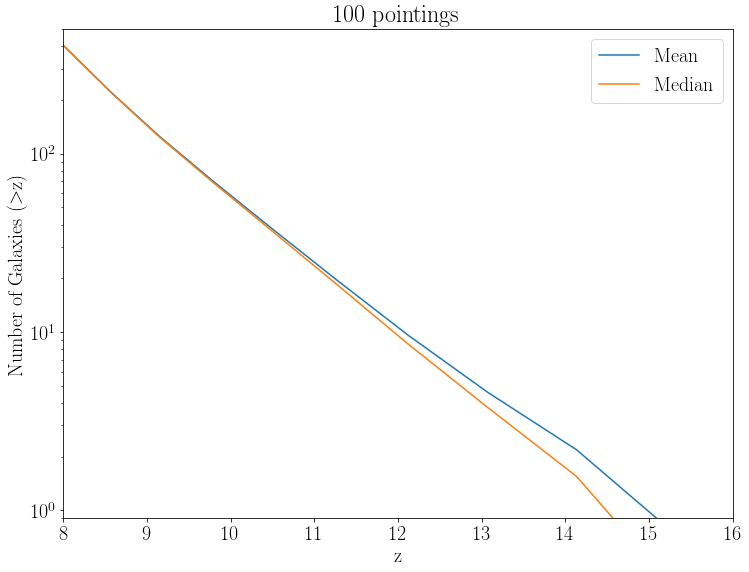

In [25]:
fig, ax =plt.subplots(figsize=(12,9))
mean100final=summean/N
med100final=summed/N  
ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='100 pointings')
if save==1:
    plt.savefig("figs/"+file+"/100.pdf")

In [26]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9993506662760729
0.998975870054703


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(14.56799999999636, 15.311, 15.020999999996109)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [32:04<00:00, 38.50s/it]


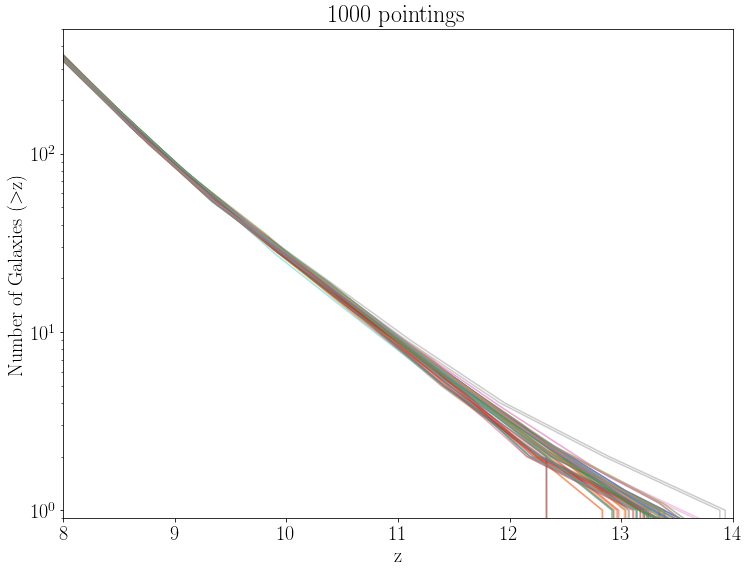

In [27]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 200 parallel pointings of JWST

    parallel_2000 = survey(28.6, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1000)
    mean_2000, med_2000, z_vals_2000 = mean_median(parallel_2000)
    summed+=med_2000
    summean+=mean_2000

    ax.plot(z_vals_2000, mean_2000, alpha=0.4, label = "Mean")
    ax.plot(z_vals_2000, med_2000, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,14), title='1000 pointings')
winsound.Beep(400,300)

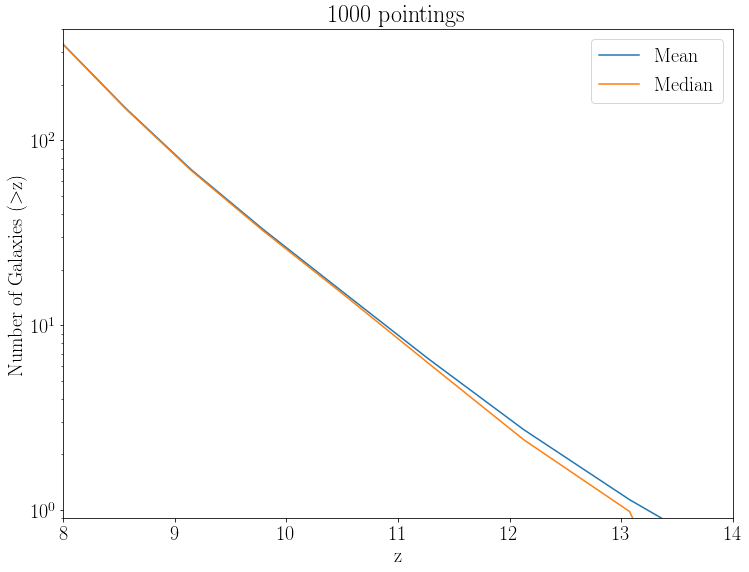

In [28]:
fig, ax =plt.subplots(figsize=(12,9))
mean1000final=summean/N
med1000final=summed/N  
ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,4e2), xlim=(8,14), title='1000 pointings')
if save==1:
    plt.savefig("figs/"+file+"/1000.pdf")

In [29]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9994074556576573
0.9995460207736326


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(13.056999999997197, 14.1315, 13.227999999997103)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [50:17<00:00, 60.35s/it]


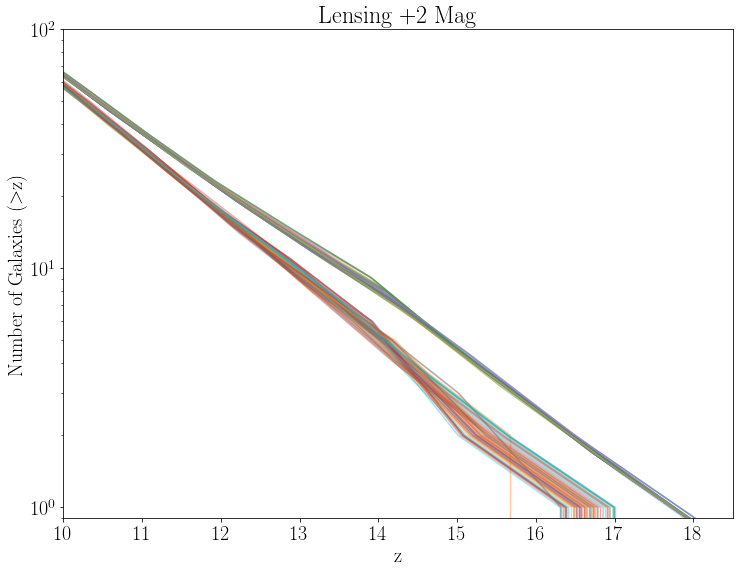

In [30]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
# Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
# Assumes this is over one JWST pointing

    lensing_2 = survey(30.7 + 2, 2*4.84/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)
    summed+=med_lens
    summean+=mean_lens

    ax.plot(z_vals_lens, mean_lens, alpha=0.4, label = "Mean")
    ax.plot(z_vals_lens, med_lens, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e2), xlim=(10,18.5), title='Lensing +2 Mag')
winsound.Beep(400,300)

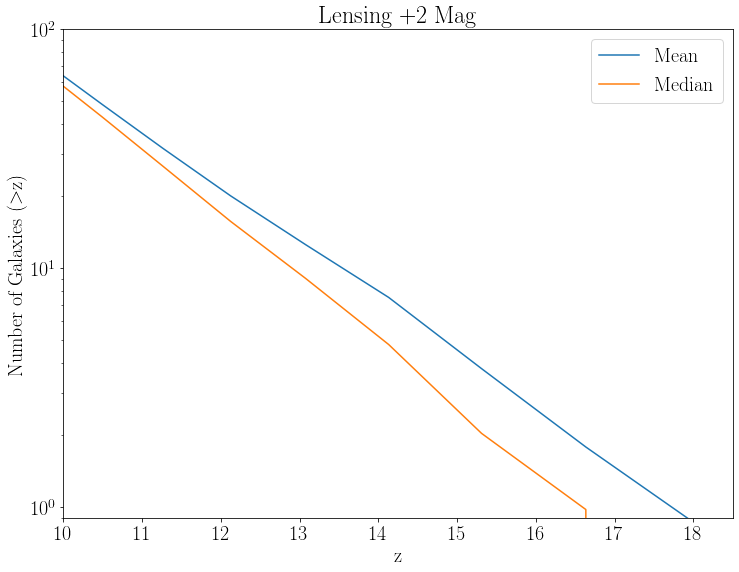

In [31]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e2), xlim=(10,18.5), title='Lensing +2 Mag')
if save==1:
    plt.savefig("figs/"+file+"/lensfull+2.pdf")

In [32]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9996137009756598
0.9998613678075546


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(16.602999999996303, 16.6345, 17.727999999997678)

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:33:24<00:00, 112.09s/it]


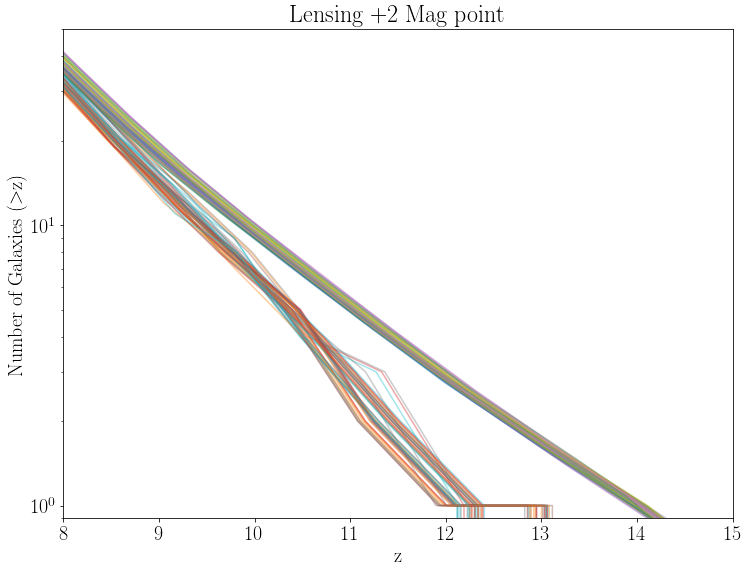

In [33]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
    # Assumes this is over one square arcsecond
    lensing_2 = survey(30.7 + 2, 1/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)
    lensing_rest = survey(30.7, 8.6/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens1, med_lens1, zvals1  = mean_median(lensing_rest)
    mean_lens+=mean_lens1
    med_lens+=med_lens1
    summed+=med_lens
    summean+=mean_lens

    ax.plot(z_vals_lens, mean_lens, alpha=0.4, label = "Mean")
    ax.plot(z_vals_lens, med_lens, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e1), xlim=(8,15), title='Lensing +2 Mag point')
winsound.Beep(400,300)

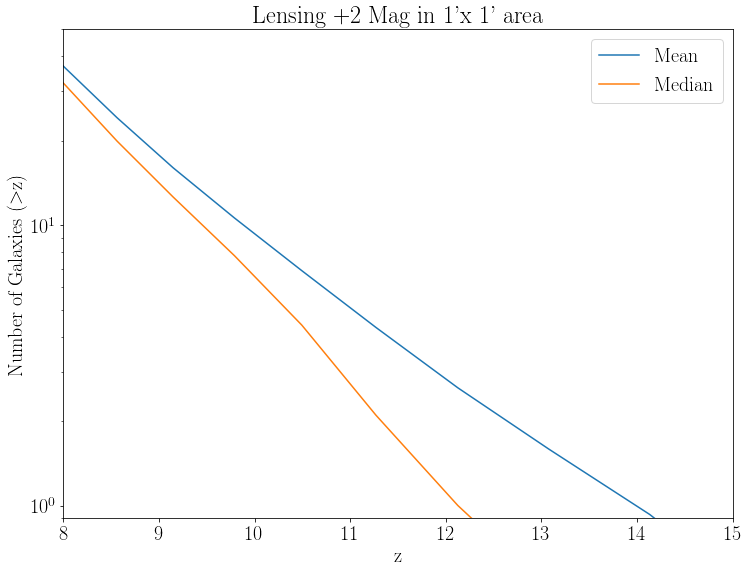

In [34]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e1), xlim=(8,15), title="Lensing +2 Mag in 1'x 1' area")
if save==1:
    plt.savefig("figs/"+file+"/lenspoint+2.pdf")

In [35]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9992761211059976
0.9998277955813647


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(12.126999999997713, 13.0755, 13.993999999996678)

In [36]:
from scipy.interpolate import interp1d
from tqdm import tqdm
N=50
def find_min(f):
    x=8
    while f(x)>1:
        x+=0.001
    print(f(x))
    return x
allmed=[]
allmedrough=[]
allmean=[]
mean_point=[]
med_pointrough=[]
med_point=[]
numpoint=10**np.arange(0,3.3,0.3)
for points in numpoint:
    summed=np.zeros(len(z_vals))
    summean=np.zeros(len(z_vals))
    for _ in tqdm(range(N)):   
        # Survey design assuming 200 parallel pointings of JWST

        parallel_2000 = survey(29.25, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), int(points))
        mean_2000, med_2000, z_vals_2000 = mean_median(parallel_2000)
        fmed = interp1d(z_vals, med_2000, 'cubic')
        fmean = interp1d(z_vals, mean_2000, "cubic")
        z_med, z_mean = find_min(fmed), find_min(fmean)
        allmed.append(z_med)
        allmean.append(z_mean)
        summed+=med_2000
        summean+=mean_2000
    fmed = interp1d(z_vals, summed/N, 'cubic')
    fmean = interp1d(z_vals, summean/N, "cubic")
    z_med, z_mean = find_min(fmed), find_min(fmean)
    z_med2=z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())]
    mean_point.append(z_mean), med_pointrough.append(z_med2), med_point.append(z_med)
winsound.Beep(400,300)

  2%|█▋                                                                                 | 1/50 [00:37<30:50, 37.76s/it]

0.9981038395202865
0.9991375096547573


  4%|███▎                                                                               | 2/50 [01:33<34:38, 43.30s/it]

0.9981083163672053
0.9997985985035354


  6%|████▉                                                                              | 3/50 [02:15<33:28, 42.74s/it]

0.9980717964109884
0.9998479217776824


  8%|██████▋                                                                            | 4/50 [02:58<32:46, 42.75s/it]

0.9981091070672327
0.9992739700327548


 10%|████████▎                                                                          | 5/50 [03:47<33:32, 44.71s/it]

0.9995685354730742
0.999514385355865


 12%|█████████▉                                                                         | 6/50 [04:29<32:10, 43.88s/it]

0.019041967858602897
0.9991670566728483


 14%|███████████▌                                                                       | 7/50 [05:22<33:22, 46.58s/it]

0.9976673204022384
0.9997894752137052


 16%|█████████████▎                                                                     | 8/50 [06:08<32:29, 46.42s/it]

0.9976661051984571
0.9987859125956594


 18%|██████████████▉                                                                    | 9/50 [06:51<31:05, 45.49s/it]

0.9995572668910787
0.9997669728483475


 20%|████████████████▍                                                                 | 10/50 [07:37<30:19, 45.48s/it]

0.9995568838519396
0.9997514108911658


 22%|██████████████████                                                                | 11/50 [08:23<29:49, 45.89s/it]

0.9981182381531339
0.9992310159909596


 24%|███████████████████▋                                                              | 12/50 [09:11<29:16, 46.23s/it]

0.9981080520739503
0.9996848830435205


 26%|█████████████████████▎                                                            | 13/50 [09:51<27:28, 44.55s/it]

0.9981083949687439
0.9993475383382282


 28%|██████████████████████▉                                                           | 14/50 [10:44<28:08, 46.90s/it]

0.9980707168113814
0.9988695136599516


 30%|████████████████████████▌                                                         | 15/50 [11:23<26:08, 44.81s/it]

0.9980718235565798
0.9993567913161597


 32%|██████████████████████████▏                                                       | 16/50 [12:10<25:41, 45.34s/it]

0.9980819977969
0.9999926958291069


 34%|███████████████████████████▉                                                      | 17/50 [13:03<26:08, 47.54s/it]

0.9980786187327433
0.9989079263100521


 36%|█████████████████████████████▌                                                    | 18/50 [13:37<23:16, 43.65s/it]

0.9981112485557442
0.9992519327983345


 38%|███████████████████████████████▏                                                  | 19/50 [14:30<23:54, 46.27s/it]

0.9976781322939692
0.9990199627429149


 40%|████████████████████████████████▊                                                 | 20/50 [15:18<23:22, 46.76s/it]

0.01903852609786011
0.9989162142034728


 42%|██████████████████████████████████▍                                               | 21/50 [15:53<20:58, 43.40s/it]

0.020367485083731297
0.9989528920307179


 44%|████████████████████████████████████                                              | 22/50 [16:53<22:30, 48.23s/it]

0.9981917491036341
0.9991743133678248


 46%|█████████████████████████████████████▋                                            | 23/50 [17:29<20:08, 44.76s/it]

0.020088619441744046
0.9997717611380124


 48%|███████████████████████████████████████▎                                          | 24/50 [18:12<19:09, 44.21s/it]

0.018898276864545226
0.9992214345221896


 50%|█████████████████████████████████████████                                         | 25/50 [19:12<20:19, 48.79s/it]

0.9980829743472497
0.9998058086839999


 52%|██████████████████████████████████████████▋                                       | 26/50 [19:40<17:07, 42.79s/it]

0.999557094735837
0.998889628250843


 54%|████████████████████████████████████████████▎                                     | 27/50 [20:33<17:32, 45.78s/it]

0.9995718578908054
0.9996004945126631


 56%|█████████████████████████████████████████████▉                                    | 28/50 [21:29<17:50, 48.65s/it]

0.9995672184907816
0.999043232499292


 58%|███████████████████████████████████████████████▌                                  | 29/50 [21:56<14:46, 42.23s/it]

0.019028674624032932
0.999872544693328


 60%|█████████████████████████████████████████████████▏                                | 30/50 [22:56<15:52, 47.61s/it]

0.9980719124652896
0.9997488928978024


 62%|██████████████████████████████████████████████████▊                               | 31/50 [23:40<14:41, 46.38s/it]

0.020076984631206718
0.9988024366390128


 64%|████████████████████████████████████████████████████▍                             | 32/50 [24:16<12:59, 43.32s/it]

0.9995714430193172
0.9992892930221093


 66%|██████████████████████████████████████████████████████                            | 33/50 [25:17<13:49, 48.79s/it]

0.01995835714216261
0.999678934961893


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [25:54<12:03, 45.22s/it]

0.9995715248633497
0.999297506338074


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [26:40<11:22, 45.47s/it]

0.9980821490028613
0.9990164435403166


 72%|███████████████████████████████████████████████████████████                       | 36/50 [27:37<11:25, 48.96s/it]

0.9981080420322508
0.9999850626558785


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [28:07<09:22, 43.27s/it]

0.9976669647595028
0.9992572161893978


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [29:03<09:25, 47.09s/it]

0.9976659861982494
0.9999041087913024


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [29:52<08:41, 47.43s/it]

0.997678262611355
0.9993696956903887


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [30:22<07:03, 42.38s/it]

0.9980674144547008
0.9990027752843298


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [31:19<07:01, 46.80s/it]

0.999447541445472
0.9996059403002865


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [32:00<05:59, 44.99s/it]

0.9993989043773309
0.9994526069829448


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [32:39<05:03, 43.30s/it]

0.998240743667878
0.9993670421428774


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [33:35<04:41, 46.89s/it]

0.019028676839206657
0.9995231886736544


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [34:11<03:39, 43.88s/it]

0.019028657166350826
0.9996243453740923


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [35:01<03:02, 45.69s/it]

0.9981080184341787
0.998867210125383


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [35:54<02:23, 47.79s/it]

0.9980787409698779
0.9989397120256354


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [36:34<01:30, 45.34s/it]

0.9980674483706413
0.9990764586622617


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [37:25<00:47, 47.12s/it]

0.9980674219345047
0.9988406771932845


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [38:07<00:00, 45.76s/it]
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0.9976670249605806
0.9995286447924782
0.8362556482649143
0.9994561892942578


  2%|█▋                                                                                 | 1/50 [00:47<38:26, 47.07s/it]

0.9981197173800899
0.9995324149727304


  4%|███▎                                                                               | 2/50 [01:37<38:26, 48.04s/it]

0.9980796607536692
0.999118275204756


  6%|████▉                                                                              | 3/50 [02:27<38:00, 48.52s/it]

0.9980674221672181
0.9996940545219605


  8%|██████▋                                                                            | 4/50 [03:14<37:04, 48.36s/it]

0.01902895635674357
0.9999080273468295


 10%|████████▎                                                                          | 5/50 [04:03<36:21, 48.48s/it]

0.9981197176828837
0.9993881969814628


 12%|█████████▉                                                                         | 6/50 [04:58<36:54, 50.33s/it]

0.997677928339878
0.9989415723175813


 14%|███████████▌                                                                       | 7/50 [05:39<34:07, 47.62s/it]

0.019003025417703334
0.9996230213660512


 16%|█████████████▎                                                                     | 8/50 [06:27<33:22, 47.69s/it]

0.9995557966195124
0.9989188300724235


 18%|██████████████▉                                                                    | 9/50 [07:20<33:43, 49.36s/it]

0.9980675274057169
0.9991416911045118


 20%|████████████████▍                                                                 | 10/50 [07:56<30:07, 45.19s/it]

0.9981112856071942
0.9991467727234036


 22%|██████████████████                                                                | 11/50 [08:51<31:24, 48.32s/it]

0.9995681488659641
0.9994101382240294


 24%|███████████████████▋                                                              | 12/50 [09:32<29:04, 45.91s/it]

0.9976682939381554
0.9988755634486092


 26%|█████████████████████▎                                                            | 13/50 [10:08<26:36, 43.15s/it]

0.9982407100098568
0.9991626318854572


 28%|██████████████████████▉                                                           | 14/50 [11:08<28:48, 48.02s/it]

0.019038718552516123
0.9996266575343425


 30%|████████████████████████▌                                                         | 15/50 [11:41<25:23, 43.52s/it]

0.020077022440158552
0.9992804428604837


 32%|██████████████████████████▏                                                       | 16/50 [12:28<25:17, 44.63s/it]

0.9982402368962447
0.9997642978392554


 34%|███████████████████████████▉                                                      | 17/50 [13:25<26:35, 48.35s/it]

0.9980717886525952
0.9998168053285915


 36%|█████████████████████████████▌                                                    | 18/50 [13:51<22:11, 41.62s/it]

0.03512537665518299
0.9990370625347729


 38%|███████████████████████████████▏                                                  | 19/50 [14:46<23:39, 45.79s/it]

0.9980674408369781
0.9989158031394482


 40%|████████████████████████████████▊                                                 | 20/50 [15:35<23:17, 46.57s/it]

0.9981197147477192
0.9988854324226728


 42%|██████████████████████████████████▍                                               | 21/50 [16:04<19:54, 41.20s/it]

0.020393129538601246
0.9998814160219293


 44%|████████████████████████████████████                                              | 22/50 [17:06<22:12, 47.59s/it]

0.9980675557449212
0.9991913873810712


 46%|█████████████████████████████████████▋                                            | 23/50 [17:48<20:42, 46.02s/it]

0.9995728564855781
0.9999095112278206


 48%|███████████████████████████████████████▎                                          | 24/50 [18:25<18:44, 43.25s/it]

0.9980829816904645
0.9990592727533298


 50%|█████████████████████████████████████████                                         | 25/50 [19:27<20:24, 48.96s/it]

0.9980829103412027
0.999475032973882


 52%|██████████████████████████████████████████▋                                       | 26/50 [20:00<17:36, 44.02s/it]

0.020087881661032765
0.9989673928487163


 54%|████████████████████████████████████████████▎                                     | 27/50 [20:52<17:46, 46.35s/it]

0.9976670500102996
0.9992127282493554


 56%|█████████████████████████████████████████████▉                                    | 28/50 [21:51<18:22, 50.13s/it]

0.9981036630961753
0.9994025438117672


 58%|███████████████████████████████████████████████▌                                  | 29/50 [22:18<15:06, 43.16s/it]

0.9995714391453852
0.9991208841240758


 60%|█████████████████████████████████████████████████▏                                | 30/50 [23:16<15:57, 47.86s/it]

0.9976673856397884
0.9998390477026681


 62%|██████████████████████████████████████████████████▊                               | 31/50 [24:02<14:54, 47.09s/it]

0.9976670240886326
0.9996771647464776


 64%|████████████████████████████████████████████████████▍                             | 32/50 [24:35<12:53, 42.95s/it]

0.9976782542890524
0.9996896316644963


 66%|██████████████████████████████████████████████████████                            | 33/50 [25:34<13:31, 47.72s/it]

0.9995711721897779
0.9989090595943391


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [26:11<11:53, 44.57s/it]

0.9981114158197627
0.9998357040281295


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [26:55<11:03, 44.26s/it]

0.9995668492734071
0.999242298523498


 72%|███████████████████████████████████████████████████████████                       | 36/50 [28:00<11:49, 50.66s/it]

0.9980830340473058
0.9999718256538129


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [28:35<09:56, 45.88s/it]

0.019038804258732216
0.9989279019210904


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [29:34<09:56, 49.71s/it]

0.9976786000011278
0.9992954666648814


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [30:22<09:02, 49.31s/it]

0.9976782201732269
0.999568050735171


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [30:59<07:36, 45.66s/it]

0.9995572807617595
0.9995337093794718


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [31:54<07:15, 48.38s/it]

0.9982016685993162
0.9995740896281328


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [32:32<06:02, 45.28s/it]

0.9980717964697096
0.999851283198133


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [33:17<05:17, 45.34s/it]

0.02008760017516399
0.9996693649366025


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [34:09<04:42, 47.13s/it]

0.9995572772828021
0.9993616732132202


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [34:49<03:44, 44.97s/it]

0.9976783414715722
0.9989381919406916


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [35:39<03:06, 46.64s/it]

0.9981117498502308
0.9993640419967678


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [36:23<02:17, 45.81s/it]

0.9981195155399315
0.9992627679121333


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [37:07<01:30, 45.21s/it]

0.9981197136225752
0.9992835257171865


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [37:57<00:46, 46.56s/it]

0.9981184182739198
0.9996189222897346


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [38:40<00:00, 46.40s/it]
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0.99807218374423
0.9995139455777763
0.8589923649665819
0.9997714376705585


  2%|█▋                                                                                 | 1/50 [00:43<35:49, 43.87s/it]

0.9983197617867038
0.9996373151422204


  4%|███▎                                                                               | 2/50 [01:26<34:41, 43.36s/it]

0.9984401739399045
0.9999125962965453


  6%|████▉                                                                              | 3/50 [02:12<34:37, 44.20s/it]

0.9971997004470952
0.9997410650722311


  8%|██████▋                                                                            | 4/50 [02:54<33:32, 43.75s/it]

0.9968316154149937
0.9995563590597676


 10%|████████▎                                                                          | 5/50 [03:38<32:43, 43.64s/it]

0.9983321391438101
0.9994205246227558


 12%|█████████▉                                                                         | 6/50 [04:33<34:33, 47.14s/it]

0.99735965233823
0.9998602083155702


 14%|███████████▌                                                                       | 7/50 [05:15<32:39, 45.57s/it]

0.9972006095277512
0.9991680678849024


 16%|█████████████▎                                                                     | 8/50 [06:06<33:01, 47.17s/it]

0.9983561952334542
0.9997632202315553


 18%|██████████████▉                                                                    | 9/50 [06:55<32:37, 47.73s/it]

0.9983233933804423
0.9991994089052338


 20%|████████████████▍                                                                 | 10/50 [07:29<29:08, 43.71s/it]

0.9989131816249036
0.9998452048646406


 22%|██████████████████                                                                | 11/50 [08:24<30:36, 47.09s/it]

0.9988675794724688
0.9998737227236274


 24%|███████████████████▋                                                              | 12/50 [09:06<28:46, 45.42s/it]

0.9988679504125556
0.9996918403194501


 26%|█████████████████████▎                                                            | 13/50 [09:42<26:22, 42.76s/it]

0.9983197630608287
0.9997473749278133


 28%|██████████████████████▉                                                           | 14/50 [10:42<28:45, 47.92s/it]

0.9983197334994005
0.9993146442662887


 30%|████████████████████████▌                                                         | 15/50 [11:14<25:11, 43.17s/it]

0.997617012879206
0.9993819798380214
0.998753094668511


 32%|██████████████████████████▏                                                       | 16/50 [12:00<24:51, 43.86s/it]

0.9999363532002001


 34%|███████████████████████████▉                                                      | 17/50 [12:56<26:12, 47.65s/it]

0.9983197844469817
0.9990634790663828


 36%|█████████████████████████████▌                                                    | 18/50 [13:22<21:57, 41.17s/it]

0.9968665261270521
0.9997188451755059


 38%|███████████████████████████████▏                                                  | 19/50 [14:15<23:05, 44.70s/it]

0.9984330209869171
0.9990785674912775


 40%|████████████████████████████████▊                                                 | 20/50 [15:04<23:00, 46.01s/it]

0.9972678041201439
0.9998995814591194


 42%|██████████████████████████████████▍                                               | 21/50 [15:30<19:19, 39.98s/it]

0.9988985741572507
0.9993276171835904
0.9988679493479963


 44%|████████████████████████████████████                                              | 22/50 [16:27<20:56, 44.88s/it]

0.9994196486374


 46%|█████████████████████████████████████▋                                            | 23/50 [17:14<20:30, 45.57s/it]

0.998333285306885
0.9992428963692201


 48%|███████████████████████████████████████▎                                          | 24/50 [17:45<17:52, 41.23s/it]

0.9983197544253978
0.9995116055245142
0.998354122712383


 50%|█████████████████████████████████████████                                         | 25/50 [18:49<20:02, 48.12s/it]

0.9995820440007318


 52%|██████████████████████████████████████████▋                                       | 26/50 [19:26<17:54, 44.76s/it]

0.9984553697279613
0.9998823992332548
0.998439563256024


 54%|████████████████████████████████████████████▎                                     | 27/50 [20:07<16:42, 43.60s/it]

0.9992917359386985


 56%|█████████████████████████████████████████████▉                                    | 28/50 [21:05<17:34, 47.95s/it]

0.9971226001282021
0.9991296212284608


 58%|███████████████████████████████████████████████▌                                  | 29/50 [21:33<14:43, 42.08s/it]

0.9988679401529905
0.999930720785367
0.9972487196945627
0.9997021498654445

 60%|█████████████████████████████████████████████████▏                                | 30/50 [22:24<14:54, 44.70s/it]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [23:14<14:36, 46.16s/it]

0.9983541232003761
0.9996394927427524


 64%|████████████████████████████████████████████████████▍                             | 32/50 [23:47<12:41, 42.31s/it]

0.9972371425586724
0.9991024974595091
0.9983639627884868
0.9994858780678291

 66%|██████████████████████████████████████████████████████                            | 33/50 [24:43<13:07, 46.30s/it]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [25:23<11:52, 44.56s/it]

0.9984363889645594
0.9999760903241003
0.9971299649841562


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [26:04<10:50, 43.39s/it]

0.9997521060376279


 72%|███████████████████████████████████████████████████████████                       | 36/50 [26:55<10:38, 45.63s/it]

0.9983244476700948
0.9998688684454009


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [27:36<09:37, 44.39s/it]

0.9984404404352702
0.9994295895753743
0.9972350445836675


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [28:22<08:57, 44.79s/it]

0.9997468305698125


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [29:08<08:17, 45.24s/it]

0.9971997573545138
0.9993686098262812
0.9989026828446405


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [29:57<07:41, 46.16s/it]

0.9998469994302602


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [30:37<06:40, 44.46s/it]

0.998436416097322
0.999104717514742


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [31:23<05:59, 44.89s/it]

0.9989130722532941
0.99900860688515


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [32:14<05:27, 46.81s/it]

0.9988689234169739
0.99964026833417


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [32:50<04:20, 43.39s/it]

0.9976171624666461
0.9999675896039663


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [33:46<03:56, 47.35s/it]

0.9972351572831523
0.9996449949016962


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [34:26<02:59, 44.97s/it]

0.9971996778681319
0.9999565886189032


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [35:04<02:09, 43.12s/it]

0.9984402041801096
0.9997905142413647


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [36:09<01:39, 49.56s/it]

0.9972350470298267
0.9999743228262182


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [36:40<00:43, 43.98s/it]

0.9988688855977568
0.9991882018133383


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:20:24<00:00, 96.49s/it]

0.9983216484799128
0.9996569572052819


0.9990637714690084
0.999146907175078


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0.9989293098309086


  2%|█▌                                                                               | 1/50 [01:16<1:02:07, 76.08s/it]

0.9996485692688442
0.9992229306373732


  4%|███▎                                                                               | 2/50 [02:21<58:21, 72.95s/it]

0.9991713549145762
0.999224307048956


  6%|████▉                                                                              | 3/50 [03:46<59:53, 76.46s/it]

0.9996177781787527
0.9992447445706005


  8%|██████▋                                                                            | 4/50 [04:56<57:12, 74.62s/it]

0.9993371686224743
0.9993702322060082


 10%|████████▎                                                                          | 5/50 [06:12<56:18, 75.08s/it]

0.9996195234430307
0.9992446346181524


 12%|█████████▉                                                                         | 6/50 [07:34<56:24, 76.91s/it]

0.9998197369367465
0.9992129121597052


 14%|███████████▌                                                                       | 7/50 [08:43<53:36, 74.81s/it]

0.9993430892971802
0.9993276945171529


 16%|█████████████▎                                                                     | 8/50 [10:09<54:38, 78.05s/it]

0.9992948121332699
0.9991922629960828


 18%|██████████████▉                                                                    | 9/50 [11:23<52:31, 76.86s/it]

0.9998781180422891
0.9993727358143943


 20%|████████████████▍                                                                 | 10/50 [12:39<51:00, 76.51s/it]

0.9996800196627031
0.9993732309996807


 22%|██████████████████                                                                | 11/50 [14:01<50:49, 78.19s/it]

0.9999387595041144
0.9992462157093905


 24%|███████████████████▋                                                              | 12/50 [15:08<47:24, 74.85s/it]

0.9994791861298996
0.9991942402668685


 26%|█████████████████████▎                                                            | 13/50 [16:33<48:00, 77.85s/it]

0.9999528690082429
0.9988482843702354


 28%|██████████████████████▉                                                           | 14/50 [17:47<46:01, 76.70s/it]

0.9994024507903185
0.9976288291874467


 30%|████████████████████████▌                                                         | 15/50 [19:03<44:37, 76.49s/it]

0.9991356053957032
0.9987993496103125


 32%|██████████████████████████▏                                                       | 16/50 [20:27<44:42, 78.90s/it]

0.9993415231507599
0.9992476029024673


 34%|███████████████████████████▉                                                      | 17/50 [21:36<41:37, 75.69s/it]

0.9990973282811481


 36%|█████████████████████████████▌                                                    | 18/50 [22:55<41:00, 76.88s/it]

0.9994310380574415
0.9991594899048236


 38%|███████████████████████████████▏                                                  | 19/50 [23:23<32:10, 62.27s/it]

0.9992078986478826
0.9992744371198016


 40%|████████████████████████████████▊                                                 | 20/50 [23:51<25:52, 51.74s/it]

0.9992432978316852
0.9998559794248285


 42%|██████████████████████████████████▍                                               | 21/50 [24:25<22:30, 46.57s/it]

0.9992561392125421
0.9994769435165451


 44%|████████████████████████████████████                                              | 22/50 [24:48<18:21, 39.32s/it]

0.9988010014101518
0.9998201163605953
0.9992448485209708
0.999552880040267

 46%|█████████████████████████████████████▋                                            | 23/50 [25:21<16:55, 37.62s/it]

 48%|███████████████████████████████████████▎                                          | 24/50 [25:51<15:14, 35.19s/it]

0.9994309487143611
0.9996933178621941


 50%|█████████████████████████████████████████                                         | 25/50 [26:17<13:29, 32.39s/it]

0.9977789154890445
0.9999743607867446
0.9992130347226073


 52%|██████████████████████████████████████████▋                                       | 26/50 [26:55<13:38, 34.09s/it]

0.9998671978261364


 54%|████████████████████████████████████████████▎                                     | 27/50 [27:18<11:50, 30.90s/it]

0.9993934532518285
0.9993003322086473


 56%|█████████████████████████████████████████████▉                                    | 28/50 [27:50<11:29, 31.36s/it]

0.9992448062887296
0.9997960132217097


 58%|███████████████████████████████████████████████▌                                  | 29/50 [28:24<11:11, 31.97s/it]

0.9988695052283398
0.9999617869505275


 60%|█████████████████████████████████████████████████▏                                | 30/50 [28:49<09:57, 29.87s/it]

0.9992129864296619
0.9993003761430506


 62%|██████████████████████████████████████████████████▊                               | 31/50 [29:26<10:09, 32.07s/it]

0.9990875166721971
0.9992228398684624


 64%|████████████████████████████████████████████████████▍                             | 32/50 [29:50<08:54, 29.69s/it]

0.9992450865238354
0.9995966301192127


 66%|██████████████████████████████████████████████████████                            | 33/50 [30:22<08:33, 30.19s/it]

0.9993276986432784
0.9990955373710342


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [30:55<08:17, 31.07s/it]

0.9993732102918093
0.9999682044705245


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [31:19<07:13, 28.90s/it]

0.9992991688529363
0.9990605878099796
0.9991557902308191
0.999928326724676

 72%|███████████████████████████████████████████████████████████                       | 36/50 [31:57<07:23, 31.70s/it]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [32:22<06:28, 29.89s/it]

0.9990827754208372
0.9998062580651794


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [32:52<05:57, 29.77s/it]

0.999224718674978
0.9993554926893745


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [33:29<05:50, 31.88s/it]

0.9992128116313095
0.9998607038847875


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [33:51<04:51, 29.12s/it]

0.9977788597941777
0.9994351835598568
0.9993282694989176


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [34:30<04:47, 31.91s/it]

0.9990836326778116


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [34:57<04:02, 30.37s/it]

0.9992449637813151
0.9998813107532555


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [35:26<03:30, 30.03s/it]

0.9989154206948089
0.9996335369617734


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [36:02<03:10, 31.78s/it]

0.9987754832795338
0.9999424082432656


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [36:25<02:25, 29.20s/it]

0.9988078825805448
0.9991182623767781
0.9994291163507341


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [37:00<02:04, 31.01s/it]

0.9990462099255613


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [37:30<01:32, 30.74s/it]

0.9990875077326329
0.9998748577272738
0.9990891878137759


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [37:58<00:59, 29.85s/it]

0.999706099123283


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [38:39<00:33, 33.27s/it]

0.9992560785526848
0.9995090358696099


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [39:02<00:00, 46.85s/it]
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0.9987994656954344
0.9992414867245109
0.9988861621690768
0.9994447743138252
0.999322692219067


  2%|█▋                                                                                 | 1/50 [00:32<26:55, 32.98s/it]

0.9992460948749411


  4%|███▎                                                                               | 2/50 [01:04<26:01, 32.54s/it]

0.998930668000545
0.9995773412072961
0.9994106526140788


  6%|████▉                                                                              | 3/50 [01:29<23:46, 30.34s/it]

0.9998722451952076
0.9993144208458751
0.9998883954062283

  8%|██████▋                                                                            | 4/50 [02:06<24:49, 32.38s/it]

 10%|████████▎                                                                          | 5/50 [02:31<22:38, 30.18s/it]

0.9994935510741431
0.9995075262540282
0.9994437976928608


 12%|█████████▉                                                                         | 6/50 [03:02<22:12, 30.28s/it]

0.9994500118000195


 14%|███████████▌                                                                       | 7/50 [03:36<22:33, 31.49s/it]

0.9989023572221941
0.999341972736029


 16%|█████████████▎                                                                     | 8/50 [03:59<20:10, 28.83s/it]

0.9994439921885038
0.9991412555589345
0.9987799657494885


 18%|██████████████▉                                                                    | 9/50 [04:40<22:10, 32.45s/it]

0.9992326336259256


 20%|████████████████▍                                                                 | 10/50 [05:09<20:59, 31.50s/it]

0.9994892525333666
0.9995471918783432


 22%|██████████████████                                                                | 11/50 [05:38<19:54, 30.62s/it]

0.9989269442518648
0.999381570783996


 24%|███████████████████▋                                                              | 12/50 [06:14<20:34, 32.49s/it]

0.9994077083356828
0.9998663879355202


 26%|█████████████████████▎                                                            | 13/50 [06:38<18:19, 29.70s/it]

0.9988955593326254
0.9993051541252327
0.9994260980576807


 28%|██████████████████████▉                                                           | 14/50 [07:14<19:02, 31.73s/it]

0.9999107402093282


 30%|████████████████████████▌                                                         | 15/50 [07:44<18:09, 31.14s/it]

0.9993188605518868
0.9994182340670253
0.999411014616874


 32%|██████████████████████████▏                                                       | 16/50 [08:11<16:56, 29.91s/it]

0.9997462055193441
0.9994164820990019


 34%|███████████████████████████▉                                                      | 17/50 [08:49<17:47, 32.34s/it]

0.9992087279634814


 36%|█████████████████████████████▌                                                    | 18/50 [09:16<16:20, 30.63s/it]

0.9994603702510061
0.9994850796868632


 38%|███████████████████████████████▏                                                  | 19/50 [09:49<16:16, 31.50s/it]

0.9987799677029754
0.9998770347669721


 40%|████████████████████████████████▊                                                 | 20/50 [10:22<15:56, 31.90s/it]

0.9994794531298715
0.9992392361847738


 42%|██████████████████████████████████▍                                               | 21/50 [10:47<14:24, 29.80s/it]

0.9994443796913951
0.9994373736855063
0.999334899880376


 44%|████████████████████████████████████                                              | 22/50 [11:24<14:55, 31.99s/it]

0.9996728259007024


 46%|█████████████████████████████████████▋                                            | 23/50 [11:50<13:39, 30.35s/it]

0.9992857932083695
0.9995341872487812


 48%|███████████████████████████████████████▎                                          | 24/50 [12:21<13:13, 30.52s/it]

0.999443960871647
0.9990843195549662


 50%|█████████████████████████████████████████                                         | 25/50 [12:56<13:16, 31.85s/it]

0.9993231931672222
0.9995731974036586


 52%|██████████████████████████████████████████▋                                       | 26/50 [13:19<11:39, 29.14s/it]

0.9989391261890238
0.9998364049382504
0.9987799695922391
0.9996328448321854

 54%|████████████████████████████████████████████▎                                     | 27/50 [13:56<12:05, 31.56s/it]

 56%|█████████████████████████████████████████████▉                                    | 28/50 [14:23<11:03, 30.14s/it]

0.9994439566999397
0.9995950677697615


 58%|███████████████████████████████████████████████▌                                  | 29/50 [14:52<10:22, 29.65s/it]

0.9994776927662401
0.9995701774961341


 60%|█████████████████████████████████████████████████▏                                | 30/50 [15:29<10:38, 31.93s/it]

0.9994604036183812
0.9994248514807963


 62%|██████████████████████████████████████████████████▊                               | 31/50 [15:51<09:12, 29.10s/it]

0.9994123871155782
0.9994306681705427


 64%|████████████████████████████████████████████████████▍                             | 32/50 [16:26<09:14, 30.83s/it]

0.9994603628094924
0.999719464528003


 66%|██████████████████████████████████████████████████████                            | 33/50 [16:57<08:41, 30.71s/it]

0.9992856319651493
0.9990766458296954
0.9989271088987128


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [17:24<07:53, 29.61s/it]

0.9995538904698947


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [18:02<08:03, 32.20s/it]

0.9993368378796061
0.9993886776209173


 72%|███████████████████████████████████████████████████████████                       | 36/50 [18:25<06:53, 29.54s/it]

0.9994782880454783
0.9995374883474856
0.9988502122779606


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [19:01<06:49, 31.49s/it]

0.9998602300488889


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [19:33<06:19, 31.66s/it]

0.9993089339776274
0.9994097619483158
0.9988502286110332
0.9994914429718925

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [19:59<05:26, 29.70s/it]


0.9989270879880277


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [20:37<05:24, 32.42s/it]

0.9999547911592416


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [21:02<04:31, 30.14s/it]

0.9992715781220698
0.9991095860854671
0.9993367225672745


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [21:34<04:04, 30.52s/it]

0.9993147788508117


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [22:08<03:41, 31.63s/it]

0.9994604384300263
0.999778578514088


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [22:31<02:55, 29.17s/it]

0.9994794460370138
0.9998613887153082


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [23:09<02:38, 31.77s/it]

0.9989037633405583
0.9991843225807739


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [23:39<02:04, 31.10s/it]

0.9994893320479912
0.9997687096175542
0.9993366876564295


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [24:07<01:31, 30.44s/it]

0.9990464331234722


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [24:44<01:04, 32.38s/it]

0.9993366732447935
0.999077544891302


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [25:07<00:29, 29.44s/it]

0.9994933956836742
0.9994845974129543
0.9989094432814551


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [25:43<00:00, 30.86s/it]

0.9996904424665817



C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0.9992568348826877
0.99945212429099


  2%|█▋                                                                                 | 1/50 [00:30<24:54, 30.51s/it]

0.9991583575385901
0.9991949559919878
0.9991535424185634


  4%|███▎                                                                               | 2/50 [00:56<23:24, 29.27s/it]

0.9992341569031352
0.9990370318629539


  6%|████▉                                                                              | 3/50 [01:35<25:10, 32.15s/it]

0.9995555827674552


  8%|██████▋                                                                            | 4/50 [01:58<22:33, 29.42s/it]

0.9990367141162629
0.9996866621761533
0.9994812597924403


 10%|████████▎                                                                          | 5/50 [02:31<22:46, 30.36s/it]

0.9998999935651739


 12%|█████████▉                                                                         | 6/50 [03:04<22:49, 31.13s/it]

0.9994868116239364
0.9994321692274275
0.999447419075653


 14%|███████████▌                                                                       | 7/50 [03:30<21:14, 29.65s/it]

0.9999732674053241
0.9994848703048786


 16%|█████████████▎                                                                     | 8/50 [04:07<22:22, 31.96s/it]

0.9993874062951318


 18%|██████████████▉                                                                    | 9/50 [04:33<20:34, 30.11s/it]

0.9993500282550799
0.9992765961137278
0.9990292351798681
0.9999496446924011

 20%|████████████████▍                                                                 | 10/50 [05:04<20:15, 30.40s/it]

 22%|██████████████████                                                                | 11/50 [05:38<20:21, 31.33s/it]

0.9994845781304553
0.9997583066669351


 24%|███████████████████▋                                                              | 12/50 [06:01<18:20, 28.96s/it]

0.9994515463889734
0.9994715748588561
0.999034517230801


 26%|█████████████████████▎                                                            | 13/50 [06:39<19:30, 31.63s/it]

0.9998886738312003


 28%|██████████████████████▉                                                           | 14/50 [07:07<18:18, 30.50s/it]

0.9995314819917521
0.9992369657263857
0.9994741647170208


 30%|████████████████████████▌                                                         | 15/50 [07:37<17:40, 30.29s/it]

0.9998797877079514


 32%|██████████████████████████▏                                                       | 16/50 [08:13<18:15, 32.22s/it]

0.9994949444016099
0.9994449525307446


 34%|███████████████████████████▉                                                      | 17/50 [08:36<16:08, 29.34s/it]

0.9994812195241547
0.9998665651893626
0.9994955849601217


 36%|█████████████████████████████▌                                                    | 18/50 [09:13<16:54, 31.70s/it]

0.9995556602252315


 38%|███████████████████████████████▏                                                  | 19/50 [09:42<15:51, 30.69s/it]

0.9993390513594769
0.9995380925995141
0.999154607011888


 40%|████████████████████████████████▊                                                 | 20/50 [10:09<14:55, 29.86s/it]

0.9992582886766719


 42%|██████████████████████████████████▍                                               | 21/50 [10:46<15:26, 31.94s/it]

0.9994559184982275
0.999607539367906


 44%|████████████████████████████████████                                              | 22/50 [11:09<13:35, 29.14s/it]

0.9989852705252732
0.9998014012322101
0.9994942984267771


 46%|█████████████████████████████████████▋                                            | 23/50 [11:43<13:44, 30.55s/it]

0.9999202780213965


 48%|███████████████████████████████████████▎                                          | 24/50 [12:13<13:13, 30.53s/it]

0.9993474093738324
0.999181491185299
0.9994905369149376


 50%|█████████████████████████████████████████                                         | 25/50 [12:40<12:12, 29.29s/it]

0.9994557592548078
0.9994474667826304


 52%|██████████████████████████████████████████▋                                       | 26/50 [13:21<13:08, 32.83s/it]

0.9995489670184435


 54%|████████████████████████████████████████████▎                                     | 27/50 [13:46<11:42, 30.53s/it]

0.9989949883805171
0.9994796612508958
0.9991503943061713


 56%|█████████████████████████████████████████████▉                                    | 28/50 [14:19<11:29, 31.36s/it]

0.9995175938756574


 58%|███████████████████████████████████████████████▌                                  | 29/50 [14:53<11:11, 31.98s/it]

0.9990329971841425
0.9999281046433944
0.9990354206462937
0.9993380251665295

 60%|█████████████████████████████████████████████████▏                                | 30/50 [15:17<09:55, 29.75s/it]


0.9991884535229935


 62%|██████████████████████████████████████████████████▊                               | 31/50 [15:55<10:12, 32.26s/it]

0.9995922807360524


 64%|████████████████████████████████████████████████████▍                             | 32/50 [16:20<08:58, 29.93s/it]

0.9994474684929796
0.9997264341323344
0.9991534817294391


 66%|██████████████████████████████████████████████████████                            | 33/50 [16:50<08:32, 30.14s/it]

0.9994675421948424


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [17:25<08:25, 31.56s/it]

0.998986480462278
0.9993437099879905
0.9994474779212347


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [17:48<07:15, 29.03s/it]

0.9999151190032218
0.9993474857887593


 72%|███████████████████████████████████████████████████████████                       | 36/50 [18:26<07:24, 31.72s/it]

0.9992921169206865


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [18:52<06:30, 30.01s/it]

0.9994845194846759
0.999971510269554


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [19:22<05:58, 29.91s/it]

0.9994942819748596
0.9997740866598872


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [19:57<05:45, 31.43s/it]

0.9995212765241052
0.9992485510685011
0.999153528858322


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [20:20<04:48, 28.86s/it]

0.9991928484134677
0.999396953206689
0.9993514158880012

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [20:57<04:41, 31.31s/it]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [21:26<04:04, 30.59s/it]

0.9994845068505777
0.999745866993229
0.9990354289259716


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [21:54<03:28, 29.75s/it]

0.9997780308591501


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [22:31<03:11, 31.91s/it]

0.9994981493005497
0.9996180599935239


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [22:53<02:25, 29.14s/it]

0.9990330929946167
0.9996486922708532
0.9993353192285622


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [23:29<02:05, 31.26s/it]

0.9995037029061039
0.999128128144926
0.9992341271046562

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [24:00<01:33, 31.16s/it]


0.9991538155454813


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [24:26<00:59, 29.60s/it]

0.9995704984391234
0.999035553361533


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [25:04<00:31, 31.97s/it]

0.9992745599265466


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [25:29<00:00, 30.59s/it]

0.998986777173765
0.9996725323326934



C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0.999287076928312
0.9992352966034687
0.9990360964394396


  2%|█▋                                                                                 | 1/50 [00:32<26:17, 32.20s/it]

0.9996597966787083
0.9992801443013333
0.999318226518832

  4%|███▎                                                                               | 2/50 [01:04<25:46, 32.22s/it]


0.9990708698153795


  6%|████▉                                                                              | 3/50 [01:27<23:07, 29.53s/it]

0.99939403461257
0.9983763359827188


  8%|██████▋                                                                            | 4/50 [02:05<24:30, 31.96s/it]

0.9996494743778378


 10%|████████▎                                                                          | 5/50 [02:32<22:53, 30.52s/it]

0.9993122994542043
0.9994363595273538
0.9981202792737008


 12%|█████████▉                                                                         | 6/50 [03:02<22:19, 30.45s/it]

0.999785148630582


 14%|███████████▌                                                                       | 7/50 [03:37<22:41, 31.66s/it]

0.9990799286052661
0.9997496732041192


 16%|█████████████▎                                                                     | 8/50 [03:59<20:12, 28.87s/it]

0.9983867788754095
0.99993379512722
0.999118028838822


 18%|██████████████▉                                                                    | 9/50 [04:36<21:26, 31.37s/it]

0.9992797260492153


 20%|████████████████▍                                                                 | 10/50 [05:04<20:15, 30.39s/it]

0.9992795899282172
0.9994733069371409
0.9991179948787591


 22%|██████████████████                                                                | 11/50 [05:32<19:09, 29.48s/it]

0.9997024592898874
0.9992815266477464


 24%|███████████████████▋                                                              | 12/50 [06:09<20:10, 31.86s/it]

0.9995938352916639
0.9983836855504071


 26%|█████████████████████▎                                                            | 13/50 [06:32<17:58, 29.15s/it]

0.999879494815246
0.9990372068336189


 28%|██████████████████████▉                                                           | 14/50 [07:05<18:09, 30.28s/it]

0.9995508779283221
0.9983867503693947


 30%|████████████████████████▌                                                         | 15/50 [07:38<18:13, 31.24s/it]

0.999901812644918
0.9983543676645458


 32%|██████████████████████████▏                                                       | 16/50 [08:05<16:55, 29.87s/it]

0.9994675515055552
0.9990374217041886


 34%|███████████████████████████▉                                                      | 17/50 [08:43<17:44, 32.25s/it]

0.9991065888540515


 36%|█████████████████████████████▌                                                    | 18/50 [09:07<15:49, 29.68s/it]

0.99842249794178
0.9993680081782064
0.9993138945635931


 38%|███████████████████████████████▏                                                  | 19/50 [09:39<15:40, 30.35s/it]

0.9997181468101285


 40%|████████████████████████████████▊                                                 | 20/50 [10:12<15:40, 31.36s/it]

0.9990379653091968
0.9995177162440901
0.9981950936560117


 42%|██████████████████████████████████▍                                               | 21/50 [10:36<14:05, 29.16s/it]

0.9993799811866505
0.9993124496124134


 44%|████████████████████████████████████                                              | 22/50 [11:15<14:54, 31.95s/it]

0.9998391968617145


 46%|█████████████████████████████████████▋                                            | 23/50 [11:41<13:39, 30.36s/it]

0.9983867566207676
0.9996504707345595
0.9990360184990366


 48%|███████████████████████████████████████▎                                          | 24/50 [12:12<13:08, 30.31s/it]

0.9995048977668136


 50%|█████████████████████████████████████████                                         | 25/50 [12:46<13:04, 31.40s/it]

0.9992917559714057
0.9992466829199913
0.9992795678181059


 52%|██████████████████████████████████████████▋                                       | 26/50 [13:09<11:35, 29.00s/it]

0.9996277845724757
0.9988632810525716


 54%|████████████████████████████████████████████▎                                     | 27/50 [13:50<12:29, 32.60s/it]

0.9998980352008413


 56%|█████████████████████████████████████████████▉                                    | 28/50 [14:17<11:23, 31.06s/it]

0.9983944222814729
0.9996669545961728
0.998381883258273


 58%|███████████████████████████████████████████████▌                                  | 29/50 [14:48<10:47, 30.82s/it]

0.9992585563980417


 60%|█████████████████████████████████████████████████▏                                | 30/50 [15:22<10:40, 32.02s/it]

0.9990708797699361
0.9995124078709814


 62%|██████████████████████████████████████████████████▊                               | 31/50 [15:45<09:15, 29.22s/it]

0.9993138860703749
0.9999060153907121
0.9990458767861916


 64%|████████████████████████████████████████████████████▍                             | 32/50 [16:21<09:22, 31.25s/it]

0.9996959795160681


 66%|██████████████████████████████████████████████████████                            | 33/50 [16:50<08:39, 30.58s/it]

0.9981108825718914
0.9992672124712547
0.9990358239353772


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [17:18<07:54, 29.63s/it]

0.9992267731606717
0.9993438732167715


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [17:58<08:12, 32.87s/it]

0.9999955936871876
0.9983742212882619
0.9992729763371727

 72%|███████████████████████████████████████████████████████████                       | 36/50 [18:21<07:00, 30.04s/it]


0.9990438039836428


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [18:55<06:43, 31.06s/it]

0.9991904360283849


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [19:26<06:13, 31.09s/it]

0.9987596229404919
0.9995758649840863
0.9983765795627136


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [19:52<05:23, 29.42s/it]

0.9994858302807027
0.9991015590879697


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [20:28<05:14, 31.49s/it]

0.9998865843375749


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [20:53<04:25, 29.45s/it]

0.9983764765197073
0.9997135802297978
0.9981970028885924


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [21:24<04:00, 30.08s/it]

0.9997665464661306


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [21:58<03:37, 31.14s/it]

0.9993124896449139
0.9993913580239714
0.9984648403924254


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [22:21<02:53, 28.85s/it]

0.9992327736272952
0.9990801976424327


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [22:57<02:35, 31.07s/it]

0.9994417416982915


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [23:27<02:02, 30.63s/it]

0.999071770809913
0.999469343088515
0.9993140704573054


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [23:56<01:29, 29.97s/it]

0.9998822151707671


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [24:34<01:04, 32.40s/it]

0.9990863879495845
0.9994866919079145


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [24:56<00:29, 29.43s/it]

0.9983944959988497
0.9996642354509487
0.9983771335229731


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [25:31<00:00, 30.62s/it]

0.9996402804023179


0.9994226006090972


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0.9999535534921742
0.9994182796292941


  2%|█▋                                                                                 | 1/50 [00:30<24:31, 30.02s/it]

0.9996359100079883
0.9997394745070539


  4%|███▎                                                                               | 2/50 [00:55<23:01, 28.77s/it]

0.9995165011205387
0.9995475199667637


  6%|████▉                                                                              | 3/50 [01:33<24:41, 31.52s/it]

0.9995344440488315
0.9979749260931805


  8%|██████▋                                                                            | 4/50 [01:58<22:29, 29.34s/it]

0.9998718809132703
0.9994208151634255


 10%|████████▎                                                                          | 5/50 [02:31<22:59, 30.66s/it]

0.9994396149397677


 12%|█████████▉                                                                         | 6/50 [03:04<22:57, 31.30s/it]

0.999270481243522
0.9997314965639161
0.9996640152558256


 14%|███████████▌                                                                       | 7/50 [03:28<20:48, 29.03s/it]

0.9993825088485584
0.9994600363803178


 16%|█████████████▎                                                                     | 8/50 [04:06<22:18, 31.87s/it]

0.9997733867789131
0.9992757362234271
0.9997453305603371

 18%|██████████████▉                                                                    | 9/50 [04:32<20:29, 30.00s/it]


0.9994637571682564


 20%|████████████████▍                                                                 | 10/50 [05:02<20:05, 30.14s/it]

0.9995900786105704
0.9992508835045283


 22%|██████████████████                                                                | 11/50 [05:37<20:30, 31.55s/it]

0.9997316371430768


 24%|███████████████████▋                                                              | 12/50 [05:59<18:11, 28.73s/it]

0.9992707615467642
0.9997020876441208
0.9995491651140834


 26%|█████████████████████▎                                                            | 13/50 [06:37<19:22, 31.42s/it]

0.9996783590389992
0.9979175059826403


 28%|██████████████████████▉                                                           | 14/50 [07:07<18:29, 30.81s/it]

0.9995341346028273
0.9994223179541245


 30%|████████████████████████▌                                                         | 15/50 [07:35<17:29, 29.98s/it]

0.999409173163609


 32%|██████████████████████████▏                                                       | 16/50 [08:11<18:01, 31.82s/it]

0.999421590554519
0.9994145855461324


 34%|███████████████████████████▉                                                      | 17/50 [08:33<15:56, 28.98s/it]

0.9979689500217795
0.999629739708611
0.9992415505703318


 36%|█████████████████████████████▌                                                    | 18/50 [09:07<16:13, 30.44s/it]

0.9993988347835446
0.9994472144778496


 38%|███████████████████████████████▏                                                  | 19/50 [09:38<15:46, 30.54s/it]

0.9992036108999529
0.9993120185261107


 40%|████████████████████████████████▊                                                 | 20/50 [10:03<14:33, 29.13s/it]

0.9995363544833105
0.9979758148386962


 42%|██████████████████████████████████▍                                               | 21/50 [10:42<15:27, 31.98s/it]

0.9996314309370122
0.9994183143530436


 44%|████████████████████████████████████                                              | 22/50 [11:05<13:41, 29.35s/it]

0.9998373601201993
0.9979765171104422


 46%|█████████████████████████████████████▋                                            | 23/50 [11:38<13:36, 30.24s/it]

0.9993681808034465


 48%|███████████████████████████████████████▎                                          | 24/50 [12:11<13:31, 31.21s/it]

0.9995475475377913
0.999226910348506
0.9979890254672807


 50%|█████████████████████████████████████████                                         | 25/50 [12:35<12:07, 29.10s/it]

0.9993252626042712
0.99799142260872


 52%|██████████████████████████████████████████▋                                       | 26/50 [13:13<12:39, 31.65s/it]

0.9995798004278695
0.9992420750366509


 54%|████████████████████████████████████████████▎                                     | 27/50 [13:38<11:25, 29.82s/it]

0.9996574405782745
0.9995748454101194


 56%|█████████████████████████████████████████████▉                                    | 28/50 [14:07<10:50, 29.57s/it]

0.999546799091126


 58%|███████████████████████████████████████████████▌                                  | 29/50 [14:44<11:02, 31.55s/it]

0.9995812315049903
0.9993115780410639
0.9994182559323657


 60%|█████████████████████████████████████████████████▏                                | 30/50 [15:07<09:39, 28.97s/it]

0.9998705424794708
0.9994222969332242


 62%|██████████████████████████████████████████████████▊                               | 31/50 [15:42<09:46, 30.86s/it]

0.9994121987253807
0.9992854864962583


 64%|████████████████████████████████████████████████████▍                             | 32/50 [16:12<09:11, 30.62s/it]

0.999767148640025
0.9982301384803257


 66%|██████████████████████████████████████████████████████                            | 33/50 [16:40<08:26, 29.78s/it]

0.9997181621446131


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [17:17<08:32, 32.06s/it]

0.9995737120570217
0.9996861294090077
0.9993190619520463


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [17:40<07:19, 29.28s/it]

0.9997493247920702
0.9996535404844389


 72%|███████████████████████████████████████████████████████████                       | 36/50 [18:14<07:11, 30.81s/it]

0.9999240323577427
0.9992812148899618
0.9999701273362249

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [18:44<06:37, 30.55s/it]


0.9994182814594219


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [19:12<05:55, 29.60s/it]

0.9994824402199097
0.9979917947573569


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [19:49<05:50, 31.91s/it]

0.999196892314682


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [20:11<04:50, 29.05s/it]

0.9994553337003228
0.999597027866051
0.9996641519318955


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [20:44<04:32, 30.24s/it]

0.9994488817226945


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [21:16<04:05, 30.63s/it]

0.9996183247442347
0.9998934074859014
0.9992707737803745


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [21:41<03:22, 29.00s/it]

0.9995136911794353
0.999273863839106


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [22:21<03:14, 32.38s/it]

0.9999322508537696
0.9994223017391336


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [22:48<02:32, 30.58s/it]

0.9998446530578755
0.9992694338978774


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [23:20<02:03, 31.00s/it]

0.9993288906651491


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [23:54<01:36, 32.03s/it]

0.9994554644099319
0.9998674925673497
0.9995506557488978


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [24:18<00:59, 29.63s/it]

0.9994477581457929
0.9996536540285854


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [24:56<00:32, 32.19s/it]

0.9996320143882383
0.9994208204788039


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [25:21<00:00, 30.44s/it]

0.9995175123271532



C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0.9994242481566498
0.9997990935077516
0.9995848269611453


  2%|█▋                                                                                 | 1/50 [00:31<26:01, 31.87s/it]

0.9996648430123242
0.9996114788221843


  4%|███▎                                                                               | 2/50 [01:05<25:59, 32.49s/it]

0.9993686067363118
0.9994766824412323


  6%|████▉                                                                              | 3/50 [01:28<23:13, 29.65s/it]

0.9997830300150786
0.9995144305919139


  8%|██████▋                                                                            | 4/50 [02:05<24:19, 31.72s/it]

0.9999956245862028


 10%|████████▎                                                                          | 5/50 [02:32<22:44, 30.31s/it]

0.9997090083655672
0.999183215408768
0.9994741254622665


 12%|█████████▉                                                                         | 6/50 [03:01<21:59, 29.98s/it]

0.9999984527822733
0.9984710404149892


 14%|███████████▌                                                                       | 7/50 [03:36<22:31, 31.42s/it]

0.9993542533748148
0.9993642297071679


 16%|█████████████▎                                                                     | 8/50 [03:58<20:07, 28.74s/it]

0.999999660311522
0.9995528902041788


 18%|██████████████▉                                                                    | 9/50 [04:34<21:06, 30.90s/it]

0.9997886435926391
0.9996446650315987


 20%|████████████████▍                                                                 | 10/50 [05:03<20:04, 30.10s/it]

0.9999037160727352
0.9996939609603882


 22%|██████████████████                                                                | 11/50 [05:30<19:07, 29.43s/it]

0.9991358250893462
0.9993645381547429


 24%|███████████████████▋                                                              | 12/50 [06:09<20:26, 32.28s/it]

0.9991454685413399
0.9996710690449719


 26%|█████████████████████▎                                                            | 13/50 [06:33<18:23, 29.82s/it]

0.9996381366841574
0.9996278248433523


 28%|██████████████████████▉                                                           | 14/50 [07:11<19:12, 32.03s/it]

0.9994977303079117


 30%|████████████████████████▌                                                         | 15/50 [07:41<18:19, 31.42s/it]

0.9993645299523123
0.9992962046541521
0.9989271818819785


 32%|██████████████████████████▏                                                       | 16/50 [08:06<16:48, 29.66s/it]

0.9996859135756715
0.9995240263111047


 34%|███████████████████████████▉                                                      | 17/50 [08:45<17:52, 32.51s/it]

0.9991172996685823
0.9996780983585225


 36%|█████████████████████████████▌                                                    | 18/50 [09:08<15:44, 29.50s/it]

0.9999144585796874
0.9996135861932416


 38%|███████████████████████████████▏                                                  | 19/50 [09:46<16:32, 32.03s/it]

0.9999209199414189
0.999524028396384


 40%|████████████████████████████████▊                                                 | 20/50 [10:24<16:58, 33.95s/it]

0.9995825367747253
0.9996761552664413


 42%|██████████████████████████████████▍                                               | 21/50 [10:54<15:46, 32.65s/it]

0.9994646976953812
0.9995526028046069


 44%|████████████████████████████████████                                              | 22/50 [11:35<16:29, 35.33s/it]

0.9997452057293262
0.9996285139381347


 46%|█████████████████████████████████████▋                                            | 23/50 [12:02<14:39, 32.57s/it]

0.9993282385702006
0.9989270618738729


 48%|███████████████████████████████████████▎                                          | 24/50 [12:38<14:41, 33.90s/it]

0.9996600747444452
0.9996780892481916


 50%|█████████████████████████████████████████                                         | 25/50 [13:22<15:17, 36.71s/it]

0.9991652170950922
0.9996816544729968


 52%|██████████████████████████████████████████▋                                       | 26/50 [13:50<13:42, 34.26s/it]

0.9995432297081854
0.999658710547528


 54%|████████████████████████████████████████████▎                                     | 27/50 [14:34<14:11, 37.04s/it]

0.999172161033956
0.9995837975528122


 56%|█████████████████████████████████████████████▉                                    | 28/50 [15:04<12:49, 34.98s/it]

0.9993131562616346
0.9995145115372212


 58%|███████████████████████████████████████████████▌                                  | 29/50 [15:43<12:38, 36.10s/it]

0.9992634703598696
0.9996707016098306


 60%|█████████████████████████████████████████████████▏                                | 30/50 [16:23<12:26, 37.31s/it]

0.9993751436851407
0.9995177288824181


 62%|██████████████████████████████████████████████████▊                               | 31/50 [16:55<11:17, 35.63s/it]

0.9999832872869261
0.9996287814401527


 64%|████████████████████████████████████████████████████▍                             | 32/50 [17:39<11:29, 38.29s/it]

0.9993864839926178
0.9996284747889368


 66%|██████████████████████████████████████████████████████                            | 33/50 [18:14<10:35, 37.37s/it]

0.9995368717413384
0.999583998349848


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [18:52<09:57, 37.36s/it]

0.999687735727299
0.9984065804985387


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [19:32<09:34, 38.31s/it]

0.9991704684437841
0.9993226393952217


 72%|███████████████████████████████████████████████████████████                       | 36/50 [19:57<08:00, 34.32s/it]

0.9992883541586828
0.9996946459810179


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [20:47<08:25, 38.90s/it]

0.9997928949741587
0.9989271654306288


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [21:21<07:30, 37.55s/it]

0.9999257885969915
0.9996115456715184


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [22:00<06:58, 38.04s/it]

0.9994256843759886
0.9996201347717093


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [22:54<07:08, 42.81s/it]

0.9995866192325097
0.9980942528514408


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [23:20<05:38, 37.56s/it]

0.9991437365497938
0.9996201360827773


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [24:00<05:07, 38.38s/it]

0.999902919729177
0.9996808259380001


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [24:32<04:15, 36.50s/it]

0.9999053877122192
0.9995974479957302


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [25:02<03:27, 34.61s/it]

0.999729939955727
0.999658616515997


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [25:41<02:59, 35.99s/it]

0.9998780047575109
0.998571289210721


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [26:07<02:11, 32.88s/it]

0.9991383732528457
0.9995240351003676


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [26:47<01:45, 35.06s/it]

0.9993476170101756
0.9996279516282031


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [27:22<01:09, 34.95s/it]

0.9996922354490667
0.9995144342765379


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [27:53<00:33, 33.92s/it]

0.9997646993607937
0.9996746233921162


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [28:40<00:00, 34.40s/it]

0.9995367652267747


0.9993633383332464


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0.9998731736683775
0.9989298481350704


  2%|█▋                                                                                 | 1/50 [00:24<20:24, 24.99s/it]

0.9993177468768613
0.9990545547990309


  4%|███▎                                                                               | 2/50 [01:03<23:11, 28.99s/it]

0.9999908508882202
0.9994765473079105


  6%|████▉                                                                              | 3/50 [01:38<24:09, 30.84s/it]

0.9990210693022756
0.9988243602560507


  8%|██████▋                                                                            | 4/50 [02:07<23:19, 30.43s/it]

0.9991459309972142
0.9994140647551867


 10%|████████▎                                                                          | 5/50 [02:51<25:48, 34.41s/it]

0.9993655479067841
0.9992281894943763


 12%|█████████▉                                                                         | 6/50 [03:18<23:33, 32.13s/it]

0.9990635780187026
0.9995114056586452


 14%|███████████▌                                                                       | 7/50 [04:07<26:43, 37.30s/it]

0.9993240767255641
0.9994744147239317


 16%|█████████████▎                                                                     | 8/50 [04:54<28:01, 40.03s/it]

0.9996526228907444
0.9986711059359399


 18%|██████████████▉                                                                    | 9/50 [05:24<25:26, 37.23s/it]

0.9989882070044975
0.9991098157646233


 20%|████████████████▍                                                                 | 10/50 [06:07<25:55, 38.89s/it]

0.9998051476309611
0.9989084826798755


 22%|██████████████████                                                                | 11/50 [06:36<23:17, 35.83s/it]

0.9997460907345689
0.9991490871969108


 24%|███████████████████▋                                                              | 12/50 [07:12<22:45, 35.93s/it]

0.9996694568067848
0.9989430927348512


 26%|█████████████████████▎                                                            | 13/50 [07:50<22:29, 36.48s/it]

0.9994437084453129
0.9991428122176976


 28%|██████████████████████▉                                                           | 14/50 [08:19<20:35, 34.31s/it]

0.9998804704107045
0.9997046104918205


 30%|████████████████████████▌                                                         | 15/50 [09:02<21:31, 36.90s/it]

0.9990996745519868
0.9988616009229719


 32%|██████████████████████████▏                                                       | 16/50 [09:32<19:41, 34.75s/it]

0.9988823859201013
0.9988774522499066


 34%|███████████████████████████▉                                                      | 17/50 [10:07<19:08, 34.79s/it]

0.999607859191487
0.9994743342626392


 36%|█████████████████████████████▌                                                    | 18/50 [10:47<19:28, 36.53s/it]

0.9988767263925791
0.9990445546782484


 38%|███████████████████████████████▏                                                  | 19/50 [11:14<17:19, 33.55s/it]

0.9997602808310397
0.9994896478257628


 40%|████████████████████████████████▊                                                 | 20/50 [11:58<18:23, 36.77s/it]

0.9999230684666642
0.9990960210314994


 42%|██████████████████████████████████▍                                               | 21/50 [12:31<17:10, 35.54s/it]

0.9999592705203193
0.9987156660232084


 44%|████████████████████████████████████                                              | 22/50 [13:04<16:18, 34.95s/it]

0.9998019963578488
0.9991514663470922


 46%|█████████████████████████████████████▋                                            | 23/50 [13:49<17:02, 37.88s/it]

0.9989871375307164
0.9991084269878272


 48%|███████████████████████████████████████▎                                          | 24/50 [14:18<15:16, 35.25s/it]

0.9993126036254891
0.9985677378081534


 50%|█████████████████████████████████████████                                         | 25/50 [15:02<15:43, 37.74s/it]

0.9994369415628821
0.9990437518639105


 52%|██████████████████████████████████████████▋                                       | 26/50 [15:38<14:56, 37.37s/it]

0.9996540816634943
0.9994582769699215


 54%|████████████████████████████████████████████▎                                     | 27/50 [16:07<13:19, 34.74s/it]

0.999515196396665
0.9993926424345067


 56%|█████████████████████████████████████████████▉                                    | 28/50 [16:51<13:43, 37.44s/it]

0.9995702892417528
0.9994865715403207


 58%|███████████████████████████████████████████████▌                                  | 29/50 [17:19<12:11, 34.84s/it]

0.9994968403805926
0.9990314266808847


 60%|█████████████████████████████████████████████████▏                                | 30/50 [17:55<11:40, 35.01s/it]

0.9993149514526144
0.9990515878709376


 62%|██████████████████████████████████████████████████▊                               | 31/50 [18:35<11:37, 36.72s/it]

0.9994241124493349
0.9989076721101562


 64%|████████████████████████████████████████████████████▍                             | 32/50 [19:05<10:21, 34.51s/it]

0.9999762253499449
0.9988288460851059


 66%|██████████████████████████████████████████████████████                            | 33/50 [19:46<10:22, 36.63s/it]

0.9995703787613148
0.9994713275790307


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [20:15<09:07, 34.21s/it]

0.9996214115357105
0.9988575961360157


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [20:51<08:41, 34.77s/it]

0.9995417255220689
0.9991497328672798


 72%|███████████████████████████████████████████████████████████                       | 36/50 [21:26<08:06, 34.78s/it]

0.9991110110746442
0.9995137520264339


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [21:49<06:47, 31.37s/it]

0.999847908368118
0.9984627751155001


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [22:28<06:41, 33.50s/it]

0.999800182522868
0.9990819656609792


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [22:55<05:46, 31.55s/it]

0.9990812536958665
0.999163234348629


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [23:29<05:24, 32.40s/it]

0.9993581537051087
0.9988607091477811


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [24:10<05:15, 35.10s/it]

0.9994952803476277
0.9994867406484326


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [24:37<04:20, 32.56s/it]

0.9999198444100369
0.9990282331673808


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [25:17<04:02, 34.63s/it]

0.9992401664378473
0.9997061671798213


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [25:48<03:22, 33.79s/it]

0.9992001460123114
0.9994732820908532


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [26:47<03:25, 41.11s/it]

0.9992387583213703
0.9988613061788134


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [28:08<03:32, 53.12s/it]

0.9996246462493058
0.9994271486115834


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [28:44<02:24, 48.05s/it]

0.999223875027377
0.9994888541436159


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [29:18<01:27, 43.71s/it]

0.9997937996733695
0.9988636115033941


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [29:49<00:40, 40.05s/it]

0.9993849045413278
0.9994133397020002


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [30:18<00:00, 36.37s/it]

0.9997089889583234


0.9987922871617008


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0.9992054681878213
0.9978314232364658


  2%|█▋                                                                                 | 1/50 [00:39<32:06, 39.32s/it]

0.9998157272564617
0.9978724251475722


  4%|███▎                                                                               | 2/50 [01:05<28:21, 35.44s/it]

0.9992901624705909
0.9973842631825188


  6%|████▉                                                                              | 3/50 [01:38<27:11, 34.72s/it]

0.9999602236086357
0.998378827538258


  8%|██████▋                                                                            | 4/50 [02:11<26:10, 34.14s/it]

0.9995591161884423
0.9980212692476584


 10%|████████▎                                                                          | 5/50 [02:33<22:46, 30.37s/it]

0.9991766649268391
0.9983434575931094


 12%|█████████▉                                                                         | 6/50 [03:10<23:54, 32.60s/it]

0.9998808042308412
0.9991387260302145


 14%|███████████▌                                                                       | 7/50 [03:39<22:34, 31.49s/it]

0.9992213540894064
0.9981052310466778


 16%|█████████████▎                                                                     | 8/50 [04:06<20:56, 29.93s/it]

0.9991710299410618
0.9978807666427811


 18%|██████████████▉                                                                    | 9/50 [04:45<22:19, 32.67s/it]

0.999671346528678
0.9978848294973056


 20%|████████████████▍                                                                 | 10/50 [05:11<20:29, 30.74s/it]

0.9995162582647733
0.9978721586584935


 22%|██████████████████                                                                | 11/50 [05:41<19:51, 30.54s/it]

0.9990951738288107
0.9976256354351554


 24%|███████████████████▋                                                              | 12/50 [06:17<20:25, 32.26s/it]

0.9997970992658459
0.9991550420739812


 26%|█████████████████████▎                                                            | 13/50 [06:39<17:57, 29.13s/it]

0.9994710683275797
0.9989544372361551


 28%|██████████████████████▉                                                           | 14/50 [07:13<18:24, 30.69s/it]

0.9987453201105587
0.998408219560833


 30%|████████████████████████▌                                                         | 15/50 [07:49<18:50, 32.30s/it]

0.9998640088802637
0.9985671141447875


 32%|██████████████████████████▏                                                       | 16/50 [08:11<16:31, 29.16s/it]

0.9991429096221337
0.9993711005318303


 34%|███████████████████████████▉                                                      | 17/50 [08:49<17:28, 31.78s/it]

0.9999227914796575
0.9991293484121059


 36%|█████████████████████████████▌                                                    | 18/50 [09:17<16:17, 30.54s/it]

0.9993007502797008
0.9983790228749353


 38%|███████████████████████████████▏                                                  | 19/50 [09:42<14:56, 28.92s/it]

0.9995448619198525
0.9984097412444297


 40%|████████████████████████████████▊                                                 | 20/50 [10:20<15:46, 31.57s/it]

0.9992202289622666
0.9984097512375809


 42%|██████████████████████████████████▍                                               | 21/50 [10:43<14:06, 29.19s/it]

0.9993236656228729
0.9989451645855505


 44%|████████████████████████████████████                                              | 22/50 [11:14<13:47, 29.57s/it]

0.9991288370426532
0.9985077633563098


 46%|█████████████████████████████████████▋                                            | 23/50 [11:52<14:29, 32.19s/it]

0.9993100636933321
0.9982056962271033


 48%|███████████████████████████████████████▎                                          | 24/50 [12:13<12:31, 28.91s/it]

0.999179573708411
0.9978761698720406


 50%|█████████████████████████████████████████                                         | 25/50 [12:46<12:28, 29.95s/it]

0.9994396128869782
0.9978721326453578


 52%|██████████████████████████████████████████▋                                       | 26/50 [13:18<12:18, 30.78s/it]

0.9990578414009706
0.9978975180803428


 54%|████████████████████████████████████████████▎                                     | 27/50 [13:40<10:47, 28.15s/it]

0.9996097184284763
0.9977084918936217


 56%|█████████████████████████████████████████████▉                                    | 28/50 [14:18<11:18, 30.85s/it]

0.9988547030523748
0.9981977890797947


 58%|███████████████████████████████████████████████▌                                  | 29/50 [14:46<10:32, 30.12s/it]

0.999674561802516
0.999371468138195


 60%|█████████████████████████████████████████████████▏                                | 30/50 [15:11<09:29, 28.46s/it]

0.9993908826398511
0.9983342266028709


 62%|██████████████████████████████████████████████████▊                               | 31/50 [15:50<10:03, 31.74s/it]

0.9990157863837227
0.9978782073843637


 64%|████████████████████████████████████████████████████▍                             | 32/50 [16:16<09:00, 30.04s/it]

0.9991908006372963
0.9984754296508762


 66%|██████████████████████████████████████████████████████                            | 33/50 [16:47<08:34, 30.28s/it]

0.9999850698489745
0.9985249243368275


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [17:24<08:37, 32.32s/it]

0.9995777747820849
0.9982051271424857


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [17:47<07:22, 29.50s/it]

0.9988509030924555
0.9984573183094043


 72%|███████████████████████████████████████████████████████████                       | 36/50 [18:19<07:04, 30.33s/it]

0.9996531688771425
0.9976255793281027


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [18:54<06:51, 31.62s/it]

0.9992337076522141
0.9984777402068319


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [19:15<05:42, 28.57s/it]

0.9998567852407146
0.9979026495339468


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [19:51<05:36, 30.57s/it]

0.9991973209709787
0.9978867104463917


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [20:21<05:06, 30.62s/it]

0.9986133579596456
0.9985809761646163


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [20:44<04:14, 28.29s/it]

0.9988838207654526
0.998324570867016


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [21:22<04:09, 31.13s/it]

0.9997855478371624
0.9983288967583789


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [21:47<03:25, 29.42s/it]

0.999824104799096
0.9980242262287191


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [22:14<02:51, 28.54s/it]

0.9994801629404929
0.9991227205392889


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [22:52<02:37, 31.56s/it]

0.9996488125296003
0.9973845074729977


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [23:19<02:00, 30.13s/it]

0.9995667398709471
0.9983437496460025


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [23:59<01:38, 32.90s/it]

0.9991358523942874
0.998185705098057


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [24:41<01:11, 35.73s/it]

0.9996125698793563


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [25:04<00:32, 32.03s/it]

0.9983248697196117
0.9991218958359677
0.9978722270118358


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [25:44<00:00, 30.89s/it]

0.9999315507364639


0.9982793069379958
0.9990656276115761


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add


In [37]:
close=[]
for point in med_point:
    close.append(74-np.argmin(abs(z_vals-point)))
close, med_point

([60, 60, 61, 63, 64, 65, 66, 67, 68, 68, 69],
 [8,
  8,
  8.816999999999547,
  9.74899999999903,
  10.494999999998617,
  11.269999999998188,
  12.091999999997732,
  13.099999999997173,
  13.956999999996698,
  14.547999999996371,
  15.311999999995948])

In [38]:
allmed=np.array(allmed).reshape(11,50)
staterr=np.std(allmed, axis=1)
close=[]
for point in med_point:
    close.append(74-np.argmin(abs(z_vals-point)))
syserr=[]
k=0
for p in close:
    err=z_vals[p+1]-z_vals[p-1]
    if np.isclose(staterr[k], 0):
        syserr.append(err/8)
    else:
        syserr.append(err/12)
    k+=1
syserr=np.array(syserr)
errs=np.sqrt(staterr**2+syserr**2)
errs

array([0.08651012, 0.08645786, 0.30398866, 0.24908249, 0.184875  ,
       0.2039375 , 0.17654729, 0.65307247, 0.34091177, 0.5478964 ,
       0.312875  ])

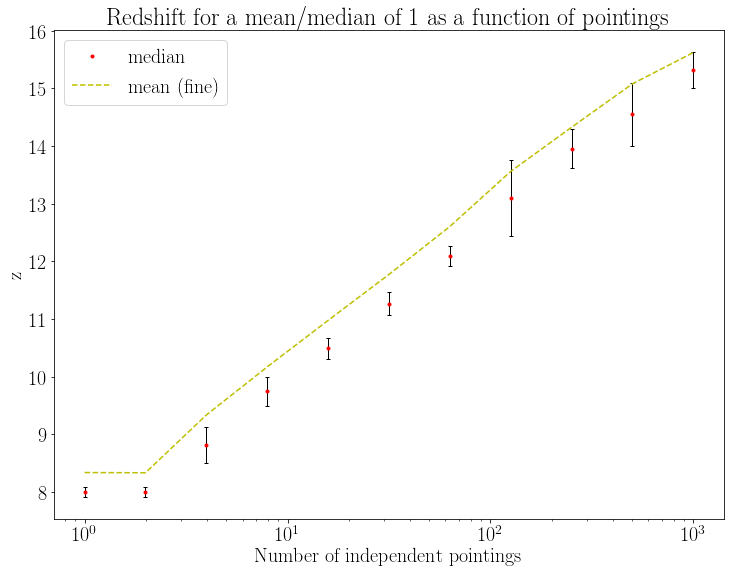

In [39]:
fig, ax=plt.subplots(figsize=(12,9))
ax.plot(numpoint, med_point, 'r.', label='median')
ax.errorbar(numpoint, med_point, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
ax.plot(numpoint, mean_point, 'y--', label='mean (fine)')
ax.set(xlabel='Number of independent pointings', ylabel='z',xscale='log',
       title='Redshift for a mean/median of 1 as a function of pointings')
ax.legend()

[1.16641847 7.77215556]
[1.1804264  7.23187639]


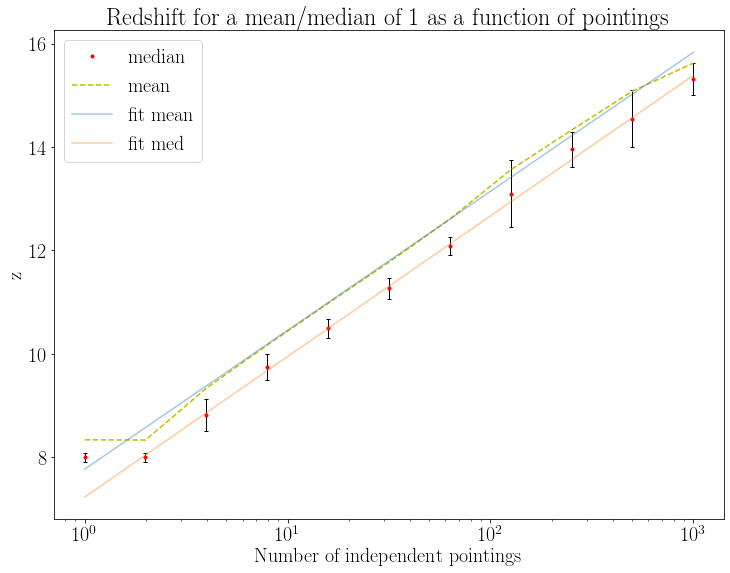

In [40]:
from scipy.optimize import curve_fit
k1=2
k2=2
plot=1
def pol(x,b,c):
    return np.log(x)*b+c

vals, cov=curve_fit(pol, numpoint[k1:], mean_point[k1:], p0=[0.01,-10])
if plot:
    fig, ax=plt.subplots(figsize=(12,9))
    ax.plot(numpoint, med_point, 'r.', label='median')
    ax.errorbar(numpoint, med_point, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
    ax.plot(numpoint, mean_point, 'y--', label='mean')
    ax.plot(numpoint, pol(numpoint, vals[0], vals[1]), alpha=0.4, label='fit mean')
print(vals)
vals, cov=curve_fit(pol, numpoint[k2:], med_point[k2:], p0=[0.01,-10], sigma=errs[k2:])
if plot:
    ax.plot(numpoint, pol(numpoint, vals[0], vals[1]), alpha=0.4, label='fit med')
    ax.set(xlabel='Number of independent pointings', ylabel='z',xscale='log',
           title='Redshift for a mean/median of 1 as a function of pointings')
    ax.legend();
print(vals)
res=0
for i in range(len(numpoint[k2:])):
    res+=(med_point[k2+i]-pol(numpoint[k2+i], vals[0], vals[1]))**2/errs[k2+i]**2
from scipy.stats import chi2
1-chi2.cdf(res, len(numpoint[k2:])-2), np.exp(1/vals[0])
plt.savefig('figs/'+file+'/funcpoint.pdf')

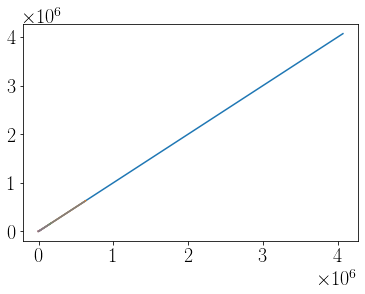

In [41]:
plt.plot(mean1000final, med1000final)
plt.plot(mean100final, med100final)
plt.plot(mean20final, med20final)
plt.plot(mean1final, med1final)
plt.plot(meandeepfinal, meddeepfinal)
plt.plot(meandeepEfinal, meddeepEfinal)
plt.plot(meanwidefinal, medwidefinal)
plt.plot(meanwideEfinal, medwideEfinal)

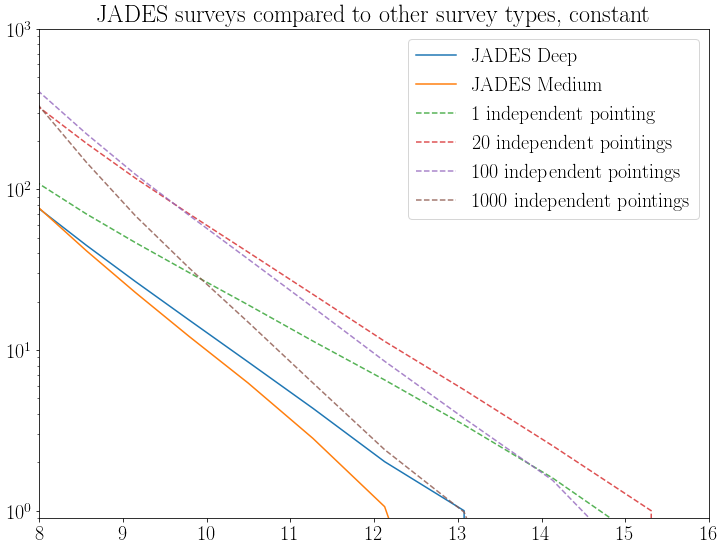

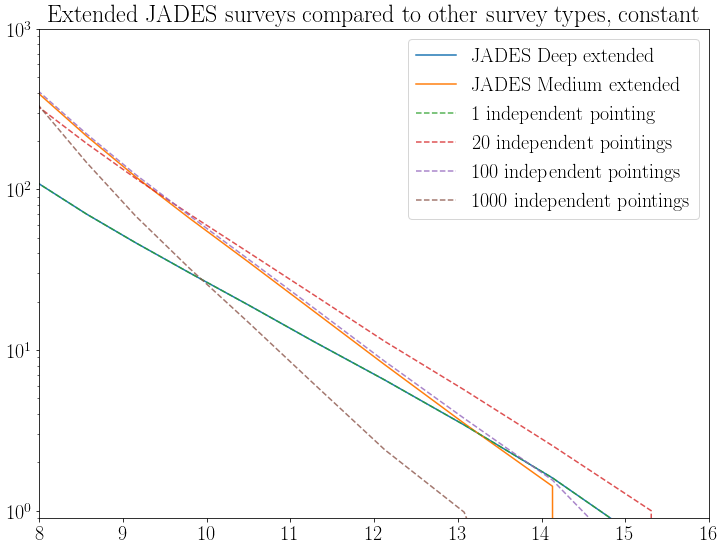

In [42]:
fig, ax = plt.subplots(1, figsize=(12,9))
ax.plot(z_vals, meddeepfinal, label='JADES Deep')
ax.plot(z_vals, medwidefinal, label='JADES Medium')
ax.plot(z_vals, med1final,alpha=0.8, linestyle='dashed', label='1 independent pointing')
ax.plot(z_vals, med20final, alpha=0.8, linestyle='dashed', label='20 independent pointings')
ax.plot(z_vals, med100final, alpha=0.8, linestyle='dashed', label='100 independent pointings')
ax.plot(z_vals, med1000final, alpha=0.8, linestyle='dashed', label='1000 independent pointings')
ax.set(ylim=(0.9,1e3), xlim=(8,16), yscale='log', title='JADES surveys compared to other survey types, constant')
ax.legend()

fig, ax = plt.subplots(1, figsize=(12,9))
ax.plot(z_vals, meddeepEfinal, label='JADES Deep extended')
ax.plot(z_vals, medwideEfinal, label='JADES Medium extended')
ax.plot(z_vals, med1final,alpha=0.8, linestyle='dashed', label='1 independent pointing')
ax.plot(z_vals, med20final, alpha=0.8, linestyle='dashed', label='20 independent pointings')
ax.plot(z_vals, med100final, alpha=0.8, linestyle='dashed', label='100 independent pointings')
ax.plot(z_vals, med1000final, alpha=0.8, linestyle='dashed', label='1000 independent pointings')
ax.set(ylim=(0.9,1e3), xlim=(8,16), yscale='log', title='Extended JADES surveys compared to other survey types, constant')
ax.legend()
plt.savefig('figs/'+file+'/JADES_comparison.pdf')